In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import tqdm
np.set_printoptions(precision=4)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from einops import rearrange, reduce
import pytorch_warmup as warmup

from gpt_adaln_no_autoreg import Transformer
# from gpt_core import Transformer, EMA

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [2]:
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

np.min(kdtree_positions_world, axis=0), np.max(kdtree_positions_world, axis=0)

(array([ 0.    , -0.0216]), array([0.2625, 0.3031]))

In [3]:
class ImitationDataset(Dataset):
    def __init__(self, states, actions, next_states, pos, num_agents, rewards, done):
        self.states = states
        self.actions = actions
        self.next_states = next_states
        self.pos = pos
        self.num_agents = num_agents
        self.rewards = rewards
        self.done = done

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]
        next_states = self.next_states[idx]
        pos = self.pos[idx]
        num_agents = self.num_agents[idx]
        reward = self.rewards[idx]
        done = self.done[idx]
        return state, action, next_states, pos, reward, done, num_agents

def get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples:int=None):
    """ If num_samples, return a smaller dataset divided equally amnong multiple objects """
    if num_samples is None:
        return ImitationDataset(states, actions, next_states, pos, num_agents, rewards, done)
        
    chosen_indices = np.random.choice(np.arange(len(states)), num_samples, replace=False)
    final_indices = np.array(chosen_indices)

    smol_states = states[final_indices]
    smol_actions = actions[final_indices]
    smol_next_states = next_states[final_indices]
    smol_pos = pos[final_indices]
    smol_num_agents = num_agents[final_indices]
    smol_rewards = rewards[final_indices]
    smol_done = done[final_indices]
    return ImitationDataset(smol_states, smol_actions, smol_next_states, smol_pos, smol_num_agents, smol_rewards, smol_done)

def get_dataset_and_dataloaders(train_bs:int=128, val_bs:int=128, test_bs:int=1, num_samples:int=1000, rb_path='../../data/replay_buffer.pkl'):
    replay_buffer = pkl.load(open(rb_path, 'rb'))

    rewards = replay_buffer['rew']
    idxs1 = np.where(rewards > -20)[0]
    idxs2 = np.where(rewards != 0)[0]
    idxs = np.intersect1d(idxs1, idxs2)

    states = replay_buffer['obs'][idxs]
    actions = replay_buffer['act'][idxs]
    next_states = replay_buffer['obs2'][idxs]
    pos = replay_buffer['pos'][idxs]
    num_agents = replay_buffer['num_agents'][idxs]
    rewards = replay_buffer['rew'][idxs]
    done = replay_buffer['done'][idxs]
    
    dataset = get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples=num_samples)

    train_size = 0.7
    val_size = 0.15
    test_size = 0.15
    train_indices, temp_indices = train_test_split(list(range(len(dataset))), test_size=(val_size + test_size))
    val_indices, test_indices = train_test_split(temp_indices, test_size=(test_size / (test_size + val_size)))

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False)
    return train_loader, val_loader, test_loader

In [4]:
num_samples = 5000
train_loader, val_loader, test_loader = get_dataset_and_dataloaders(train_bs=128, val_bs=128, test_bs=1, num_samples=num_samples, rb_path='../../data/new_replay_buffer.pkl')

In [5]:
len(train_loader), len(val_loader), len(test_loader)

(28, 6, 750)

In [6]:
# print(state_scaler.scaler.mean_, state_scaler.scaler.var_, action_scaler.scaler.mean_, action_scaler.scaler.var_, obj_name_encoder.classes_)

# dic = {'state_scaler': state_scaler, 'action_scaler': action_scaler, 'obj_name_encoder': obj_name_encoder}
# pkl.dump(dic, open('normalizer_bc.pkl', 'wb'))

In [7]:
n_epochs = 300
hp_dict = {
        "exp_name"          : "MABC",
        "data_dir"          : "./data/rl_data",
        'warmup_iters'      : 50,
        'lr'                : 1e-4,
        'eta_min'           : 1e-6,
        'q_lr'              : 1e-4,
        'q_eta_min'         : 1e-6,
        'epochs'            : n_epochs,
        'ckpt_dir'          : './matil_expt_1.pth',
        'idx_embed_loc'     : './idx_embedding_new.pth',

        # DiT Params:
        'state_dim'         : 6,
        'action_dim'        : 2,
        'act_limit'         : 0.03,
        'gamma'             : 0.99,
        "device"            : torch.device(f"cuda:1"),
        "model_dim"         : 256,
        "num_heads"         : 8,
        "dim_ff"            : 512,
        "n_layers_dict"     : {'encoder':5, 'actor': 10, 'critic': 10},
        "dropout"           : 0,
        "max_grad_norm"     : 1,
        'gauss'             : True,
        'masked'            : True,
        'adaln'             : True,  
    }
# Implementation TODOs:
#   1. Add KL Divergence loss
#   2. Add normalization
#   3. Add CAWR        

model = Transformer(hp_dict)
ema_model = deepcopy(model).to(hp_dict['device'])
model.to(hp_dict['device'])
# optimizer = optim.SGD(model.parameters(), lr=hp_dict['lr'])
optimizer_actor = optim.Adam(model.decoder_actor.parameters(), lr=hp_dict['lr'], weight_decay=1e-6)
optimizer_critic = optim.Adam(model.decoder_critic.parameters(), lr=hp_dict['q_lr'], weight_decay=1e-6)

# optimizer = optim.SGD(model.parameters(), lr=1e-2)
lr_scheduler_actor = CosineAnnealingWarmRestarts(optimizer_actor, T_0=20, T_mult=2, eta_min=hp_dict['eta_min'])
lr_scheduler_critic = CosineAnnealingWarmRestarts(optimizer_critic, T_0=20, T_mult=2, eta_min=hp_dict['q_eta_min'])

# ema = EMA(ema_model, **hp_dict['EMA Params'])

In [8]:
#load state dict
# model.load_state_dict(torch.load('mabc_new_data_ac_gauss.pth', weights_only=False)['model'])


In [9]:
pi_losses = []
q_losses = []
val_pi_losses = []
val_q_losses = []
global_Step = 0
start_value = 1
end_value = 1e2
steps = hp_dict['warmup_iters']

increment = (end_value - start_value) / (steps - 1)
values = [start_value + i * increment for i in range(steps)]

for param_group in optimizer_actor.param_groups:
    param_group['lr'] = hp_dict['eta_min']
for param_group in optimizer_critic.param_groups:
    param_group['lr'] = hp_dict['q_eta_min']

for epoch in range(hp_dict['epochs']):
    with tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=True, mininterval=1) as t:
        for i, (s1, a, s2, p, r, d, N) in enumerate(t):
            N = int(torch.max(N))
            
            # Noised and Denoised Variable
            actions = a[:, :N].to(hp_dict['device'])

            # Conditioning Variables
            states = s1[:, :N].to(hp_dict['device'])
            next_states = s2[:, :N].to(hp_dict['device'])
            pos = p[:, :N].to(hp_dict['device'])
            rewards = r.to(hp_dict['device'])
            dones = d.to(hp_dict['device'])

            optimizer_actor.zero_grad()
            pi_loss = model.compute_actor_loss(actions, states, pos)
            pi_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer_actor.step()
            
            optimizer_critic.zero_grad()
            q_loss = model.compute_critic_loss(states, actions, next_states, pos, rewards, dones)
            q_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 100.0)
            optimizer_critic.step()

            if global_Step >= (steps-1):
                lr_scheduler_actor.step()
                lr_scheduler_critic.step()
            else:
                for param_group in optimizer_actor.param_groups:
                    param_group['lr'] = hp_dict['eta_min'] * values[global_Step]
                for param_group in optimizer_critic.param_groups:
                    param_group['lr'] = hp_dict['q_eta_min'] * values[global_Step]
                    
            # lr_scheduler.step()
            pi_losses.append(pi_loss.item())
            q_losses.append(q_loss.item())
            t.set_postfix({"pi_loss":np.mean(pi_losses[-len(train_loader):]), "q_loss":np.mean(q_losses[-len(train_loader):])}, 
                          refresh=False)
            global_Step += 1
        
        ema_model.eval()        
    
    if epoch%(n_epochs//10) == 0:
        model.eval()    
        with torch.no_grad():
            with tqdm.tqdm(val_loader, desc=f"Validation Epoch {epoch}", leave=True, mininterval=1) as v:
                for i, (s1, a, s2, p, r, d, N) in enumerate(v):
                    N = int(torch.max(N))
                    
                    # Noised and Denoised Variable
                    actions = a[:, :N].to(hp_dict['device'])
                    states = s1[:, :N].to(hp_dict['device'])
                    next_states = s2[:, :N].to(hp_dict['device'])
                    pos = p[:, :N].to(hp_dict['device'])
                    rewards = r.to(hp_dict['device'])
                    dones = d.to(hp_dict['device'])
                    

                    val_pi_loss = model.compute_actor_loss(actions, states, pos).item()
                    val_q_loss = model.compute_critic_loss(states, actions, next_states, pos, rewards, dones).item()
                    
                    val_pi_losses.append(val_pi_loss)
                    val_q_losses.append(val_q_loss)

                    v.set_postfix({"val_pi_loss":np.mean(val_pi_losses[-len(train_loader):]), "val_q_loss":np.mean(val_q_losses[-len(train_loader):])}, 
                                  refresh=False)
        model.train()

Training Epoch 299: 100%|██████████| 28/28 [00:01<00:00, 18.91it/s, pi_loss=0.000154, q_loss=1.12e+7]


In [ ]:
# This block is to break the sequence of run alls
assert True == False

In [10]:
expt_dict = {"model": model.state_dict(), "optimizer_actor": optimizer_actor.state_dict(), "optimizer_critic": optimizer_critic.state_dict()}
torch.save(expt_dict, './mabc_final.pth')

In [11]:
train_losses_bkp = pi_losses
val_losses_bkp = val_pi_losses

# train_losses_bkp = q_losses
# val_losses_bkp = val_q_losses

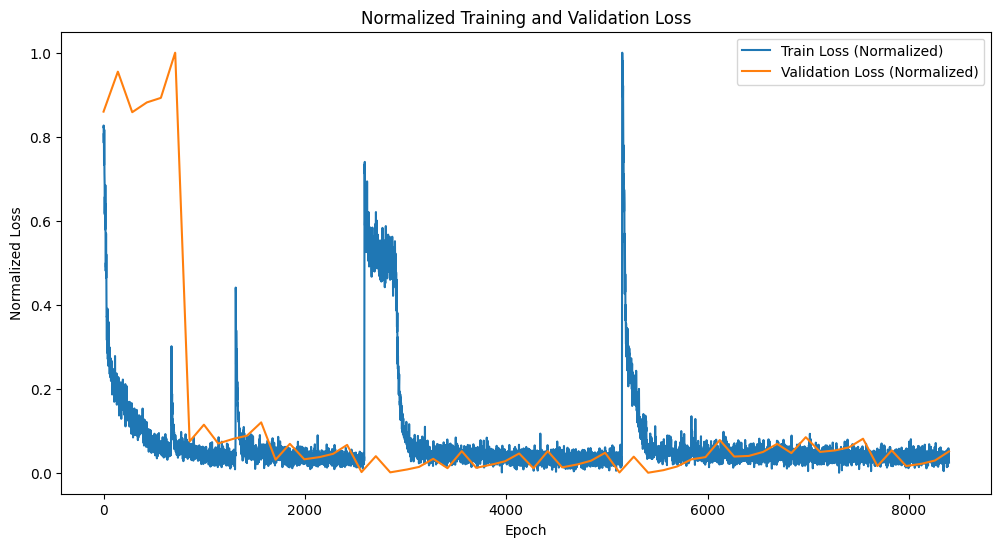

In [12]:
train_losses = np.array(train_losses_bkp[0:])
val_losses = np.array(val_losses_bkp[0:])
x_val = np.linspace(0, len(train_losses) - 1, len(val_losses))
x_train = np.arange(len(train_losses))
val_losses_interpolated = np.interp(x_train, x_val, val_losses)

# Step 2: Normalization of both losses
scaler = MinMaxScaler()


# combined_losses = np.concatenate((loss_train, loss_val_interpolated)).reshape(-1, 1)
# scaler.fit(combined_losses)

# Reshape for sklearn which expects 2D array
train_losses_normalized = scaler.fit_transform(train_losses.reshape(-1, 1)).flatten()
val_losses_normalized = scaler.fit_transform(val_losses_interpolated.reshape(-1, 1)).flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses_normalized, label='Train Loss (Normalized)')
plt.plot(val_losses_normalized, label='Validation Loss (Normalized)')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('Normalized Training and Validation Loss')
# plt.ylim(0, 0.05)
plt.legend()
plt.show()

In [13]:
# _, _, test_loader = get_dataset_and_dataloaders(train_bs=128, test_bs=1, num_samples=4000, obj_of_interest=None, rb_path='../../data/new_replay_buffer.pkl')

In [14]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go
import time

model.eval()
loss = []
statesss = []
actionsss = []
actions_gt = []
possss = []
n_agents = []

grand_data = np.zeros((100, 128, 10, 2))
with torch.no_grad():
    with tqdm.tqdm(test_loader, desc=f"Validation", leave=False, mininterval=1) as t:
        for i, (s1, a, s2, p, r, d, N) in enumerate(t):
            N = int(torch.max(N))
            n_agents.append(N)
            
            actions = a[:1, :N].to(hp_dict['device'])
            actions_gt.append(actions)

            # Conditioning Variables
            states = s1[:1, :N].to(hp_dict['device'])
            statesss.append(states)
            next_states = s2[:, :N].to(hp_dict['device'])
            # print(actions, states)
            pos = p[:1, :N].to(hp_dict['device'])
            possss.append(pos)

            now = time.time()
            output_actions = model.get_actions(states, pos, deterministic=True)
            print("time in ms: ", time.time() - now)
            actionsss.append(output_actions)
            loss.append((actions[:1, :N].cpu().detach().numpy() - output_actions.cpu().detach().numpy()).mean()**2)
            
            if i>60:
                break


Validation:   0%|          | 0/750 [00:00<?, ?it/s]

time in ms:  0.0046803951263427734
time in ms:  0.0040361881256103516
time in ms:  0.00396275520324707
time in ms:  0.003899097442626953
time in ms:  0.003895998001098633
time in ms:  0.0040700435638427734
time in ms:  0.003972530364990234
time in ms:  0.0038771629333496094
time in ms:  0.0038530826568603516
time in ms:  0.0038564205169677734
time in ms:  0.003836393356323242
time in ms:  0.0038335323333740234
time in ms:  0.00386810302734375
time in ms:  0.003827810287475586
time in ms:  0.0038928985595703125
time in ms:  0.003882169723510742
time in ms:  0.0038683414459228516
time in ms:  0.003952741622924805
time in ms:  0.0038537979125976562
time in ms:  0.0038537979125976562
time in ms:  0.0038700103759765625
time in ms:  0.003847360610961914
time in ms:  0.0038945674896240234
time in ms:  0.003865957260131836
time in ms:  0.0038340091705322266
time in ms:  0.003871917724609375
time in ms:  0.0038793087005615234
time in ms:  0.0038352012634277344
time in ms:  0.003886699676513672


time in ms:  0.004597187042236328
time in ms:  0.003909587860107422
time in ms:  0.003863811492919922
time in ms:  0.0038433074951171875
time in ms:  0.003812074661254883
time in ms:  0.003829479217529297
time in ms:  0.0038366317749023438
time in ms:  0.003869295120239258
time in ms:  0.003862619400024414
time in ms:  0.0038650035858154297
time in ms:  0.0038313865661621094
time in ms:  0.0037992000579833984
time in ms:  0.003830432891845703


2.828679637391089e-05

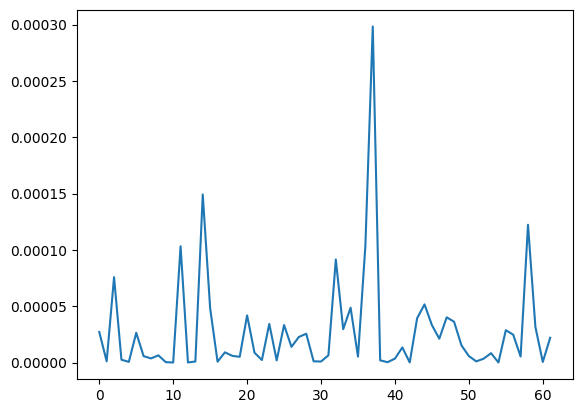

In [15]:
plt.plot(loss)
np.mean(loss)

[[ 0.0125  0.0279]
 [ 0.0267 -0.0244]
 [ 0.0295 -0.0251]
 [-0.0204  0.0299]
 [-0.0263 -0.0111]
 [ 0.0269  0.0099]
 [-0.0042 -0.0122]]
[[ 0.0106  0.0382]
 [ 0.0289 -0.0292]
 [ 0.0589 -0.0374]
 [-0.0182  0.0548]
 [-0.0299 -0.0052]
 [ 0.0626 -0.0078]
 [-0.005  -0.0087]]
7


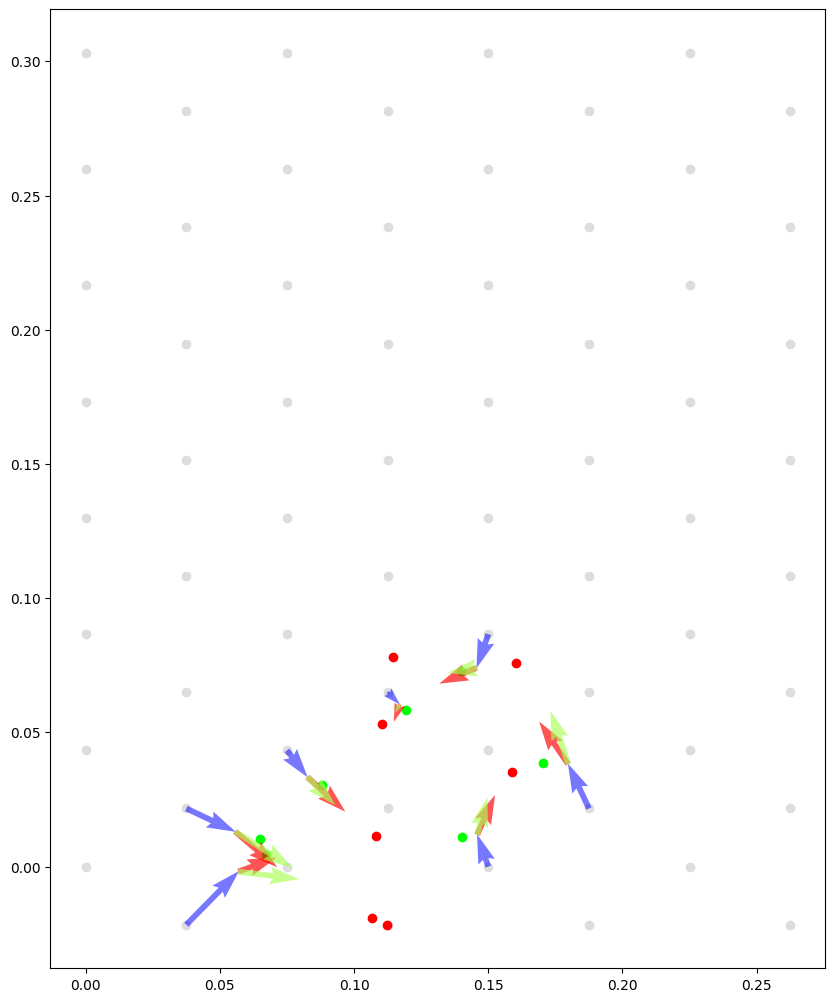

[[ 0.0167 -0.0021]
 [-0.0279 -0.0194]
 [ 0.021   0.023 ]
 [-0.0261  0.0292]
 [ 0.0058  0.0292]]
[[ 0.0152 -0.0031]
 [-0.0432 -0.0133]
 [ 0.0159  0.0222]
 [-0.0305  0.0432]
 [ 0.0051  0.0485]]
5


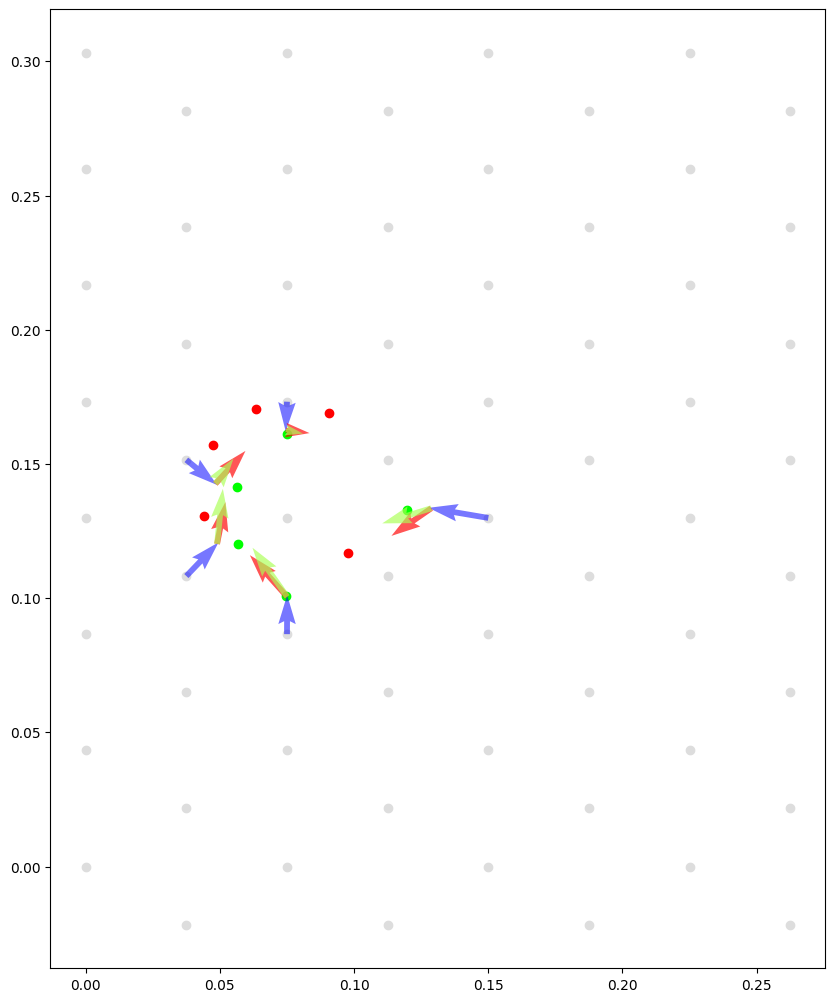

[[-0.0277  0.0027]
 [-0.0019 -0.0229]
 [ 0.0127 -0.0267]
 [ 0.0009 -0.0121]
 [-0.0283 -0.0181]
 [ 0.0125  0.0192]]
[[-0.0328 -0.0117]
 [ 0.0004 -0.0353]
 [ 0.0124 -0.047 ]
 [-0.0013 -0.0209]
 [-0.0342 -0.0351]
 [ 0.0095  0.0018]]
6


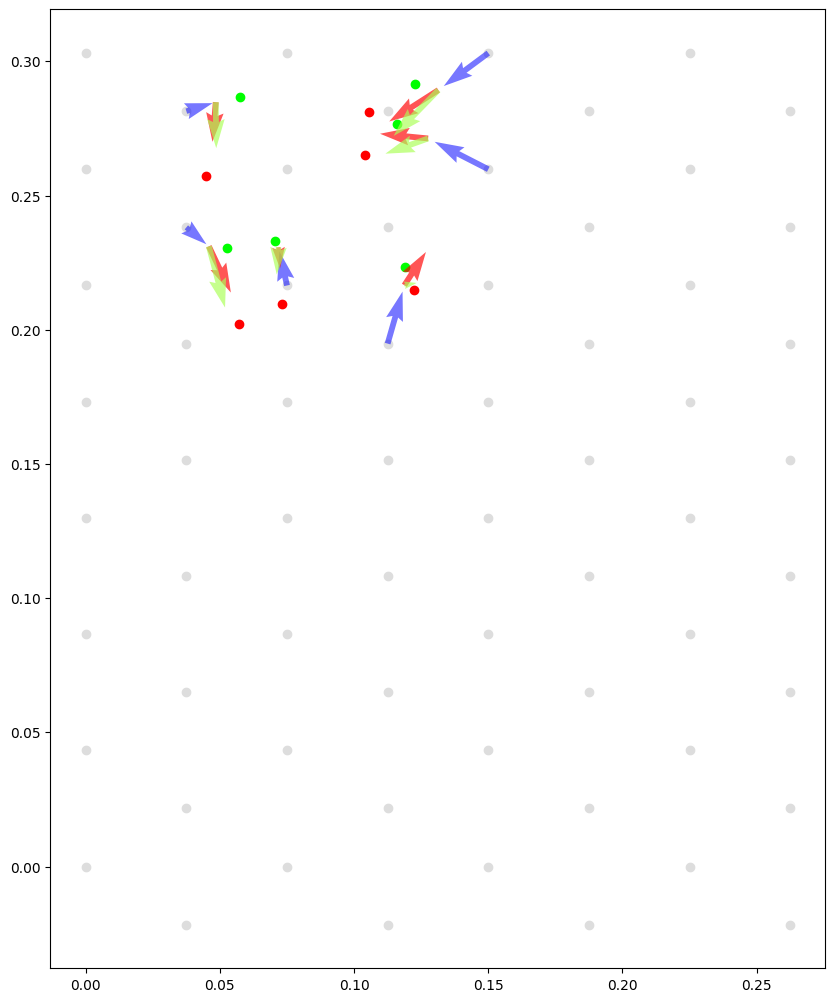

[[-0.0242 -0.0232]
 [ 0.0298 -0.0007]
 [-0.0204  0.0295]
 [ 0.0237 -0.0296]
 [-0.0266  0.0251]
 [-0.0274 -0.0298]
 [ 0.0293 -0.0259]]
[[-0.0233 -0.0165]
 [ 0.0801 -0.0044]
 [-0.0221  0.059 ]
 [ 0.0202 -0.0553]
 [-0.0245  0.0249]
 [-0.0413 -0.0658]
 [ 0.0545 -0.0337]]
7


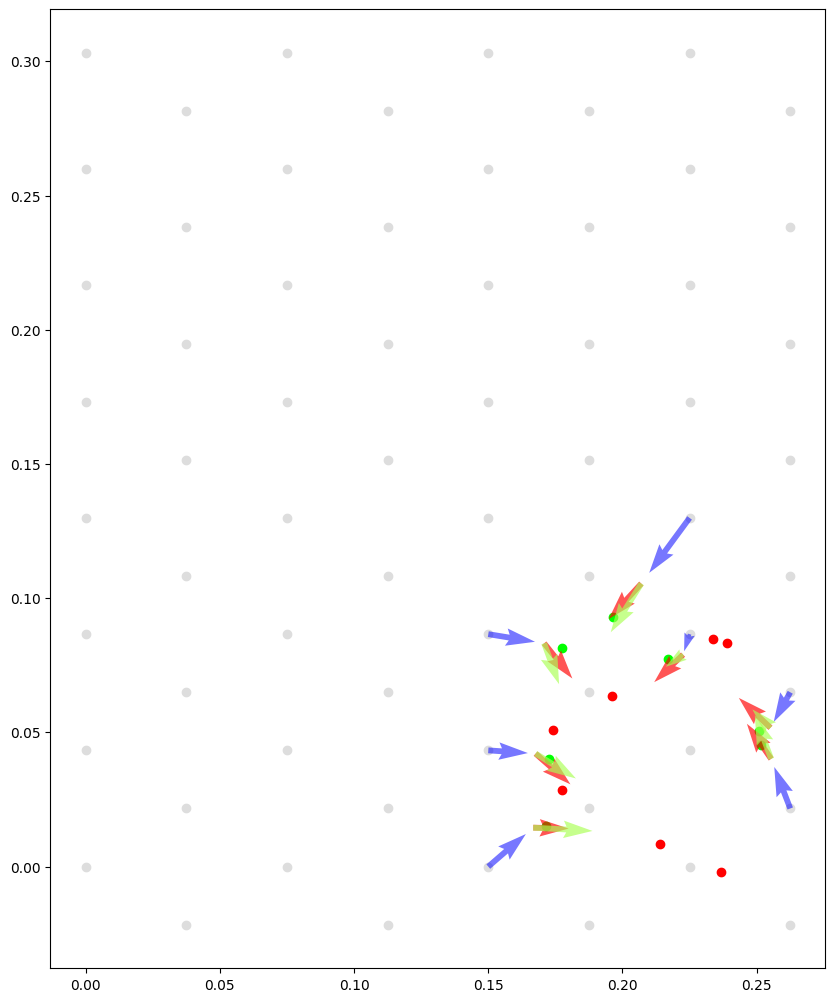

[[-0.0288  0.0296]
 [ 0.0167  0.0139]
 [-0.0294  0.0257]
 [ 0.0242 -0.0191]
 [-0.0131 -0.0224]
 [-0.0296  0.001 ]
 [ 0.0181  0.0297]]
[[-3.9442e-02  4.9836e-02]
 [ 1.4257e-02  1.0223e-02]
 [-4.5147e-02  2.4044e-02]
 [ 1.9146e-02 -1.7644e-02]
 [-6.4489e-03 -1.4672e-02]
 [-5.2667e-02  3.8869e-05]
 [ 1.8849e-02  6.7152e-02]]
7


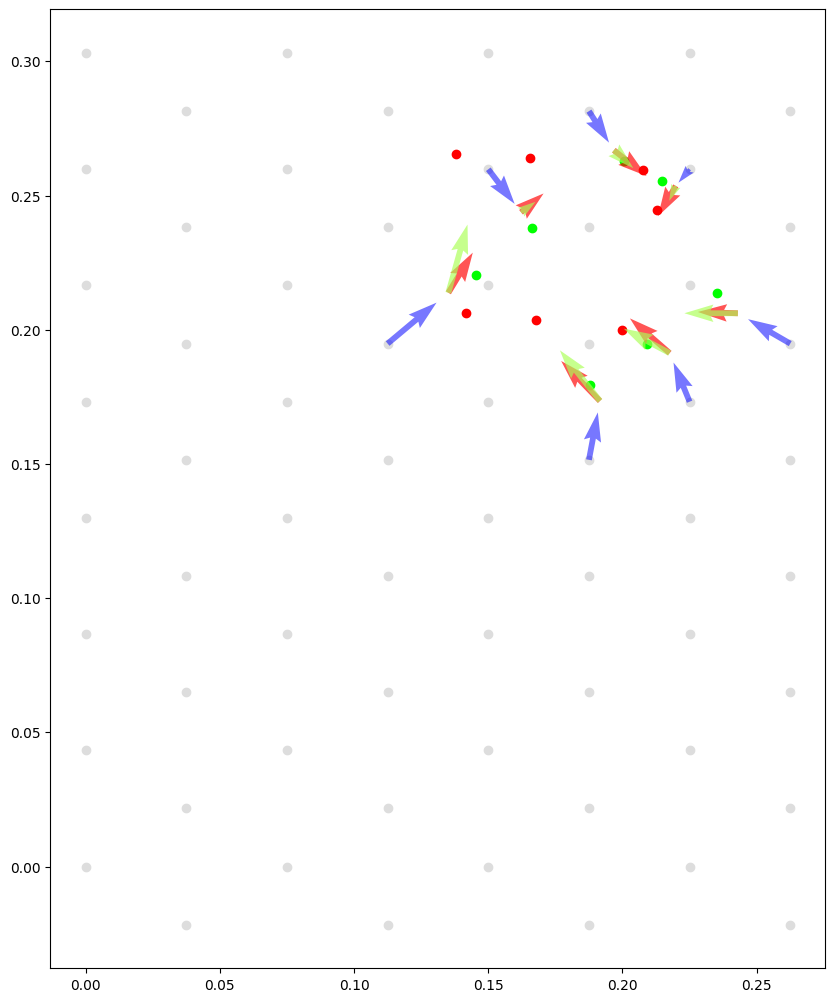

[[ 0.0172  0.0013]
 [-0.0098 -0.027 ]
 [-0.0287  0.0197]
 [-0.0161  0.0102]
 [-0.0295 -0.0256]
 [-0.0258 -0.0067]]
[[ 0.017  -0.005 ]
 [-0.005  -0.0397]
 [-0.0403  0.0176]
 [-0.0135  0.0055]
 [-0.0533 -0.0291]
 [-0.0289 -0.0078]]
6


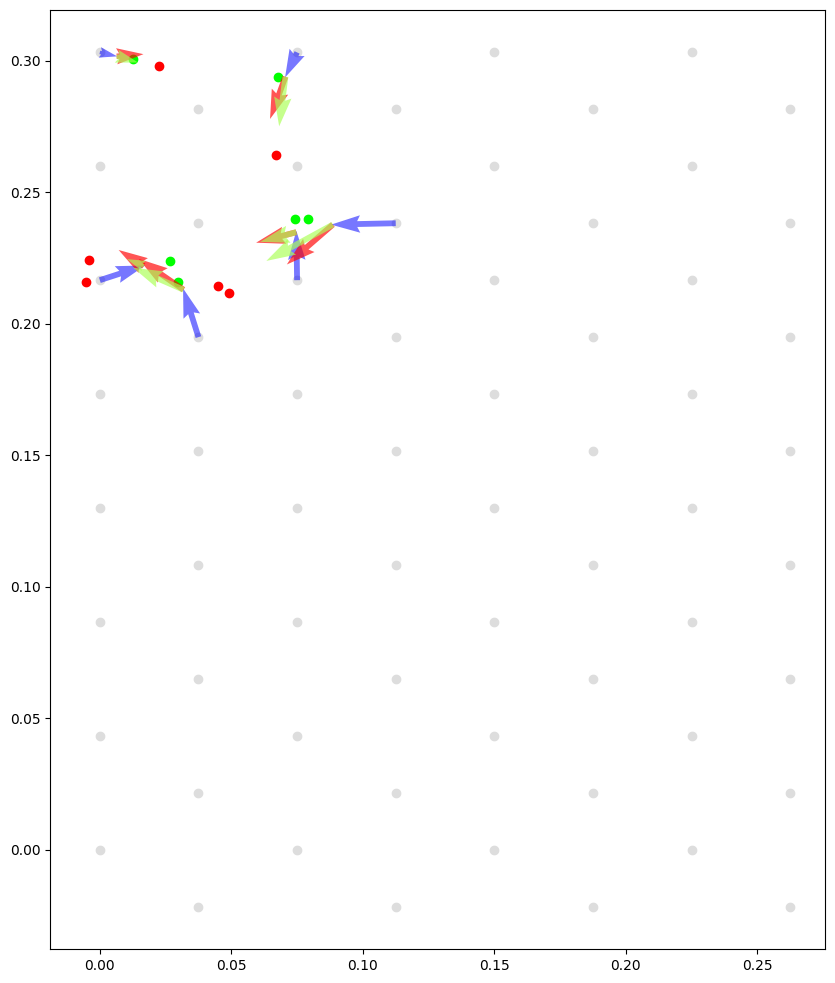

[[-0.0203  0.0281]
 [ 0.0139  0.0297]
 [-0.0087 -0.0172]
 [ 0.0233  0.0272]]
[[-0.0231  0.0429]
 [ 0.0048  0.0515]
 [-0.0168 -0.0122]
 [ 0.017   0.0311]]
4


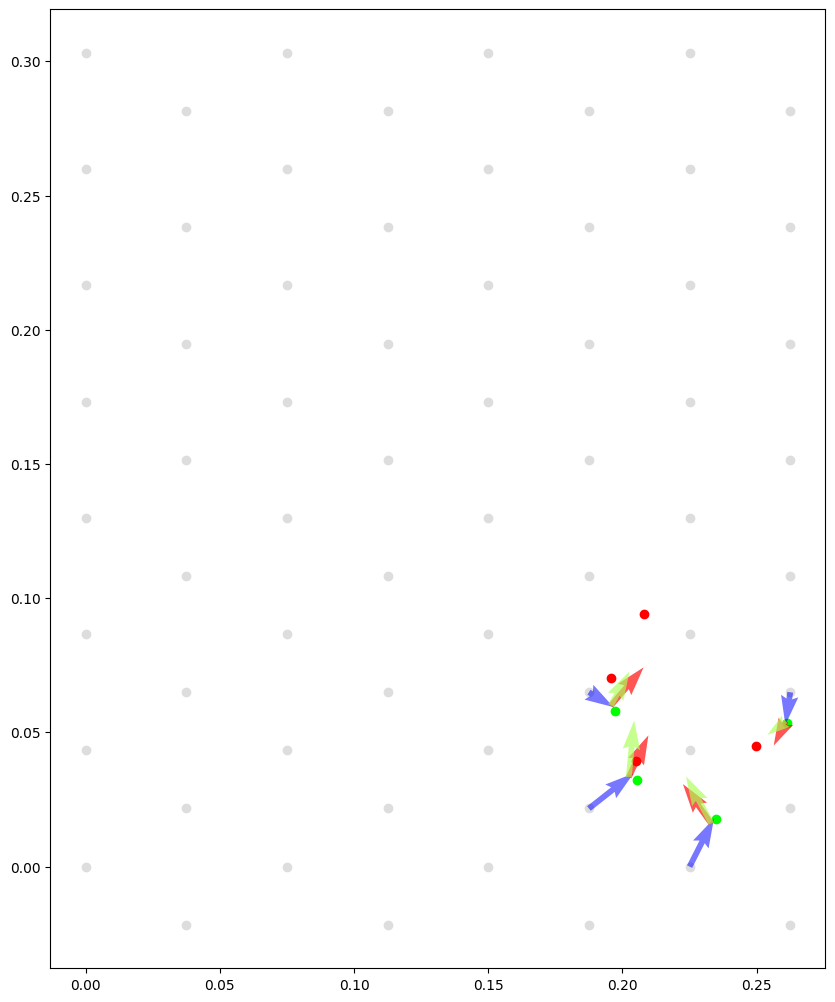

[[-0.0265 -0.0259]
 [-0.0272  0.0296]
 [ 0.0279  0.0167]
 [-0.0293  0.0264]
 [ 0.0102  0.0296]
 [-0.0151 -0.0299]
 [ 0.0276 -0.0228]]
[[-0.0311 -0.0256]
 [-0.0382  0.0613]
 [ 0.0297  0.0095]
 [-0.0433  0.0267]
 [ 0.006   0.0562]
 [-0.0182 -0.0759]
 [ 0.0331 -0.0259]]
7


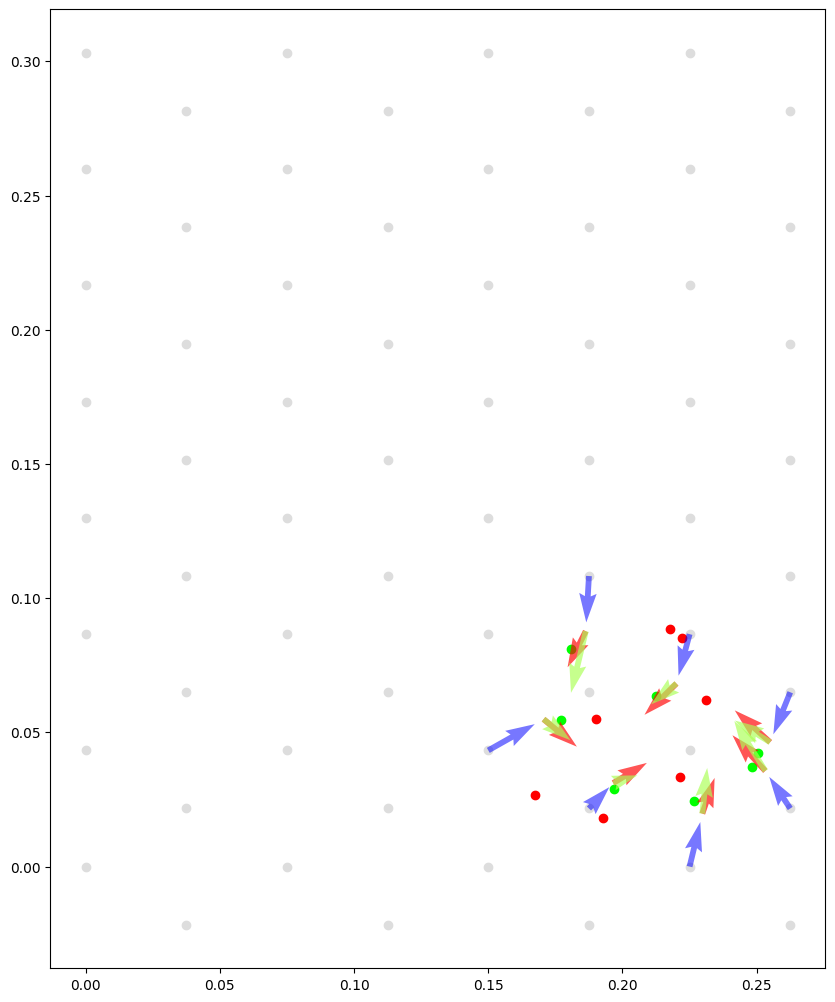

[[-0.029   0.0206]
 [ 0.0288  0.0242]
 [ 0.0063 -0.0299]
 [ 0.0278  0.0292]
 [-0.0146 -0.0285]]
[[-0.0452  0.0183]
 [ 0.0434  0.018 ]
 [ 0.0024 -0.0642]
 [ 0.0367  0.043 ]
 [-0.0085 -0.0346]]
5


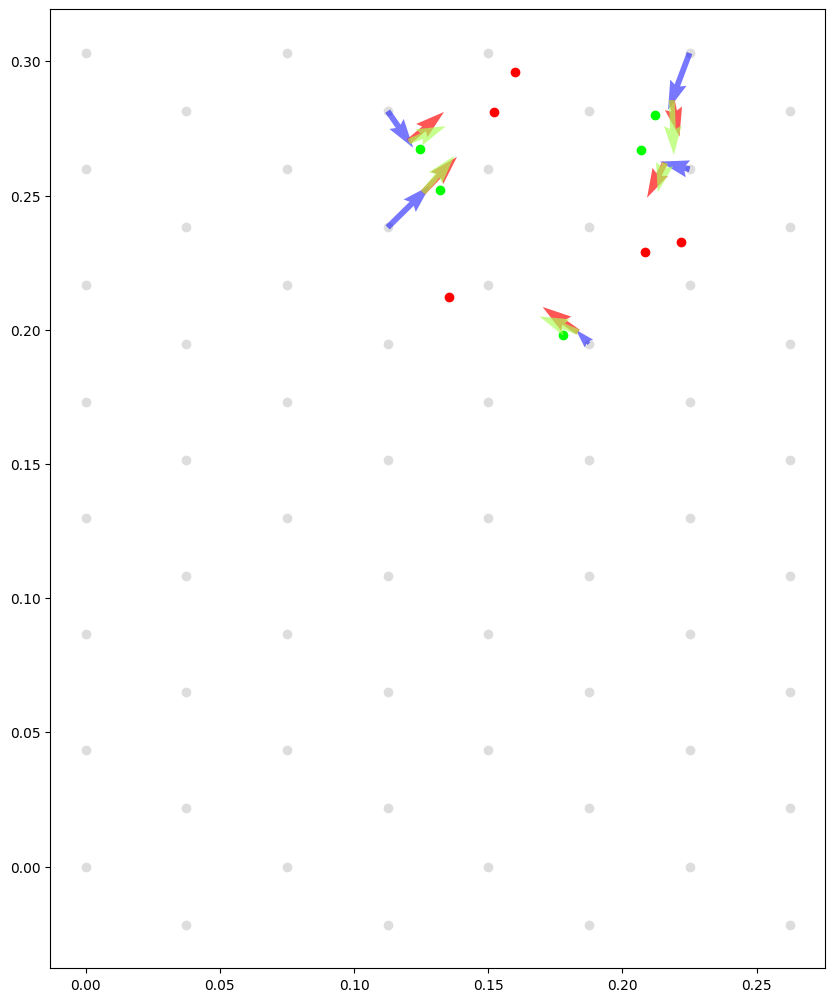

[[ 0.017  -0.0045]
 [-0.0117 -0.0117]
 [-0.0192  0.0228]
 [ 0.0158 -0.0031]
 [ 0.0169  0.0202]]
[[ 0.0085  0.0015]
 [-0.0123 -0.0049]
 [-0.0139  0.0212]
 [ 0.0076  0.002 ]
 [ 0.0069  0.02  ]]
5


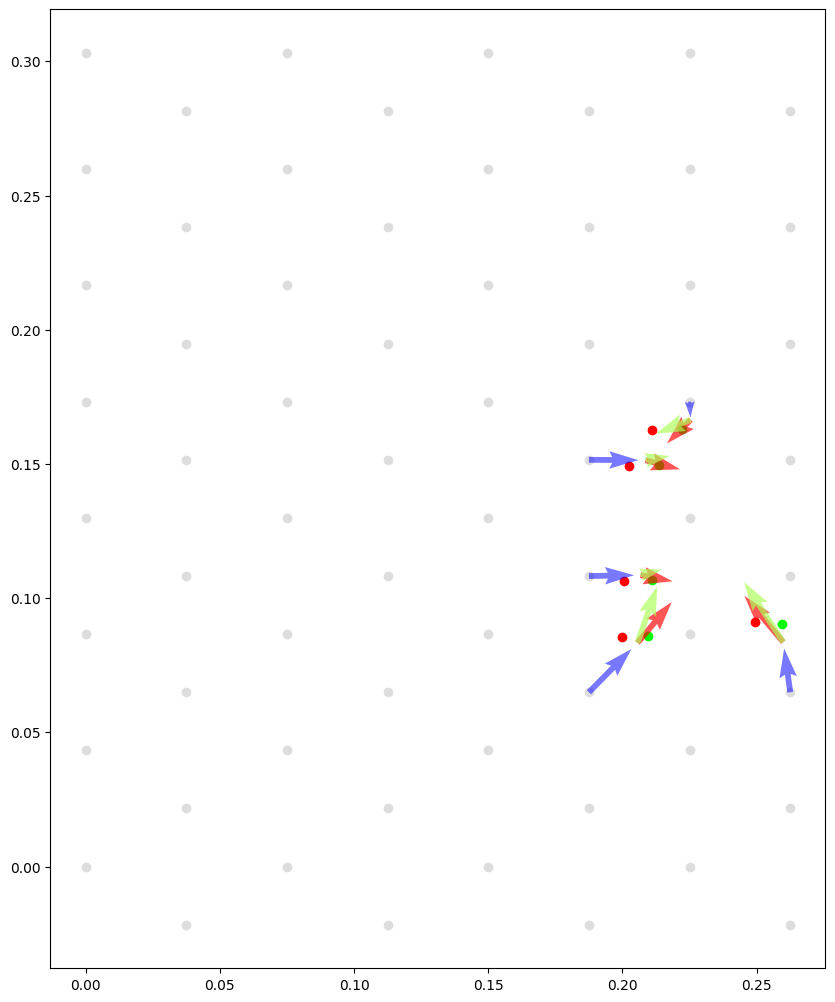

[[-0.001  -0.0145]
 [-0.0282  0.0288]
 [ 0.0233 -0.0057]
 [ 0.026  -0.0239]
 [-0.0239 -0.0013]]
[[ 0.001  -0.0102]
 [-0.039   0.0399]
 [ 0.021  -0.0067]
 [ 0.0278 -0.0248]
 [-0.0243 -0.0018]]
5


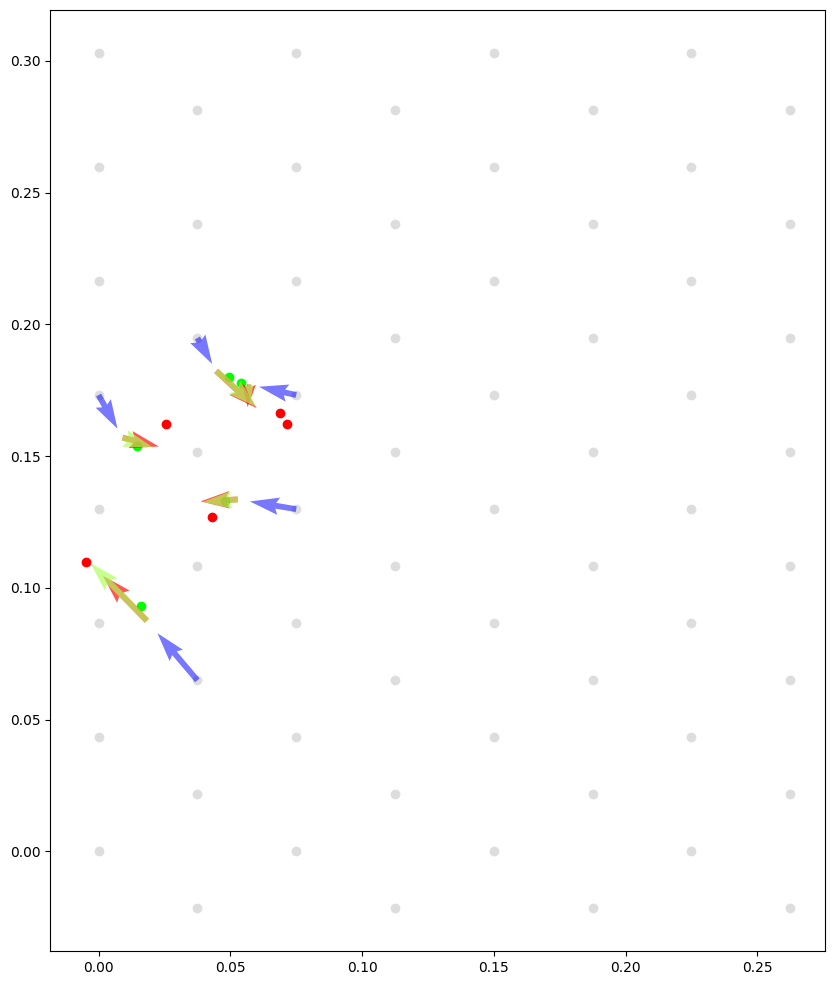

[[-0.0298 -0.0115]
 [-0.0295 -0.0204]
 [ 0.0252  0.0293]
 [-0.0293  0.0252]
 [ 0.0214 -0.0286]
 [ 0.027  -0.0226]]
[[-0.0834 -0.0049]
 [-0.0612 -0.0242]
 [ 0.0242  0.0488]
 [-0.0546  0.0221]
 [ 0.012  -0.0448]
 [ 0.0235 -0.0231]]
6


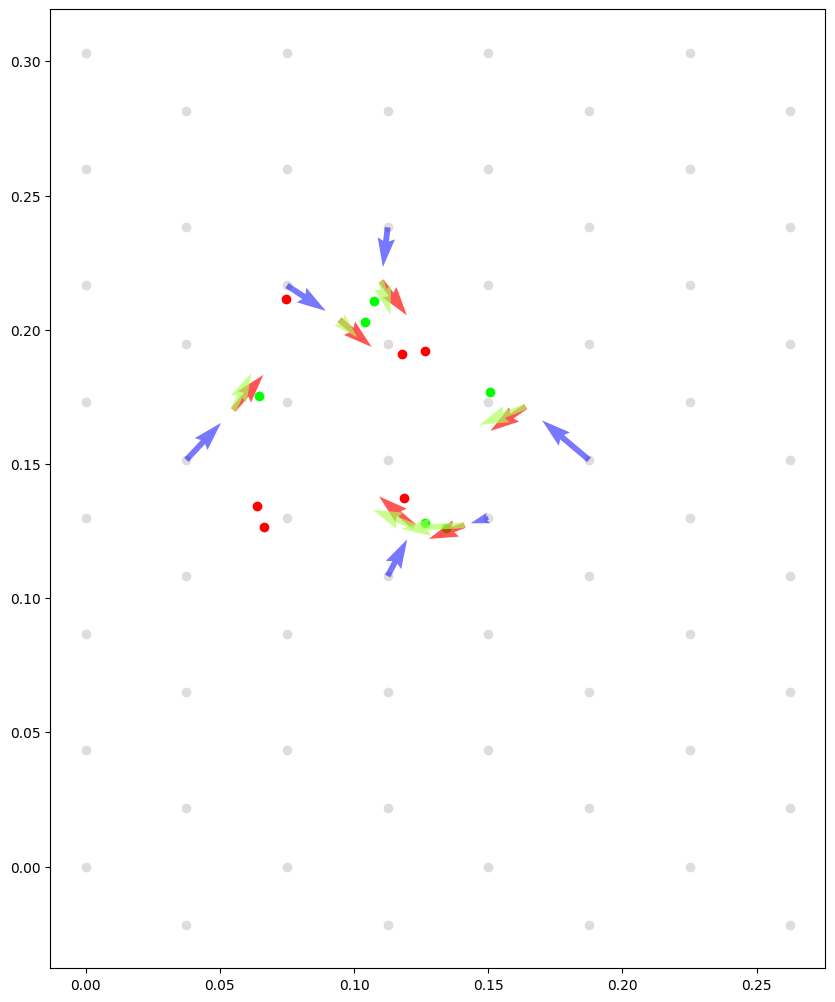

[[-0.0162  0.0226]
 [-0.0273  0.0093]
 [-0.0033  0.0144]
 [-0.0219 -0.0226]
 [-0.0244  0.0043]
 [-0.0159 -0.0098]
 [-0.0136 -0.0113]]
[[-0.0114  0.0221]
 [-0.0386  0.0063]
 [-0.0094  0.0174]
 [-0.0228 -0.0193]
 [-0.0271  0.0073]
 [-0.016  -0.0047]
 [-0.0135 -0.0108]]
7


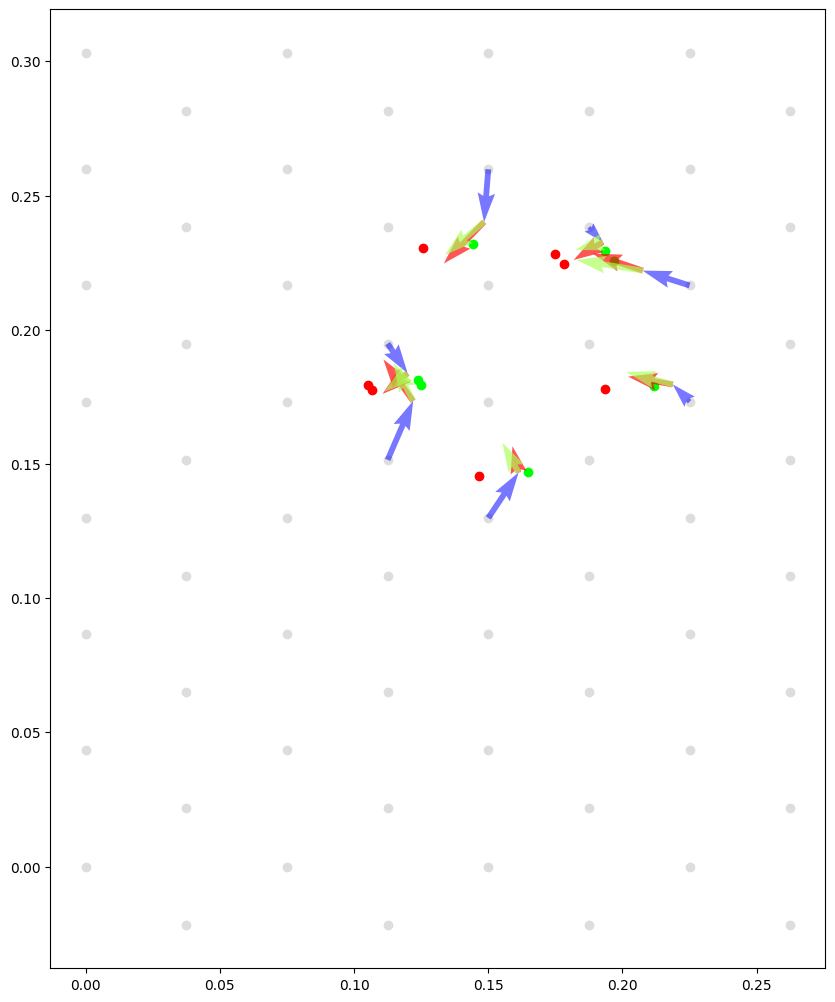

[[ 0.0219 -0.0019]
 [-0.0067  0.0184]
 [ 0.0269  0.0267]
 [ 0.0281  0.0052]
 [ 0.0166  0.0221]
 [ 0.0257 -0.0111]]
[[ 0.0155 -0.004 ]
 [-0.0067  0.0185]
 [ 0.0246  0.0274]
 [ 0.0305  0.0028]
 [ 0.0137  0.0209]
 [ 0.0241 -0.0071]]
6


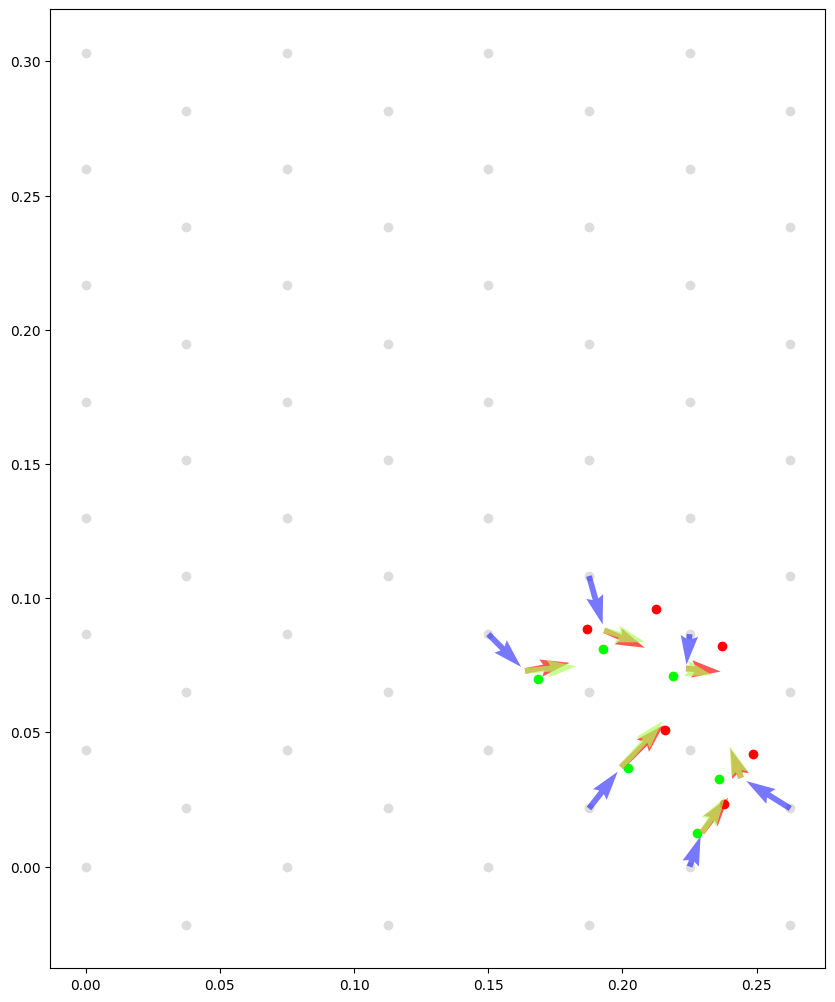

[[ 0.0204  0.029 ]
 [-0.0203  0.0247]
 [ 0.0223 -0.03  ]
 [-0.0299 -0.0235]
 [-0.0294  0.0051]
 [-0.0291 -0.0295]
 [ 0.0259 -0.0291]
 [ 0.0264 -0.0074]]
[[ 0.0195  0.0372]
 [-0.018   0.0212]
 [ 0.0253 -0.0888]
 [-0.0844 -0.0243]
 [-0.059  -0.0018]
 [-0.0546 -0.0526]
 [ 0.0315 -0.0476]
 [ 0.0308 -0.0042]]
8


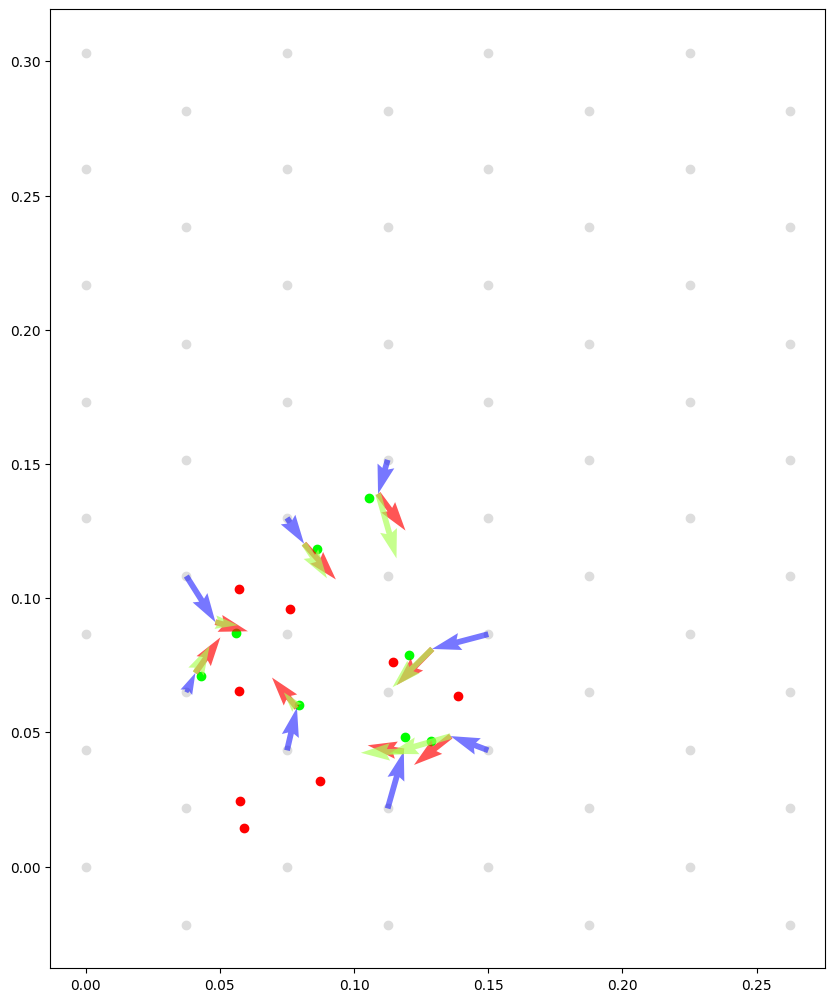

[[ 0.0012 -0.0068]
 [-0.0166 -0.0283]
 [-0.0298 -0.024 ]
 [ 0.0084 -0.0288]
 [-0.0265 -0.0203]
 [-0.0155 -0.027 ]
 [ 0.0138 -0.0149]]
[[-0.0054 -0.0054]
 [-0.0188 -0.0451]
 [-0.0602 -0.0334]
 [ 0.0044 -0.0415]
 [-0.0272 -0.0175]
 [-0.0166 -0.0358]
 [ 0.0052 -0.0151]]
7


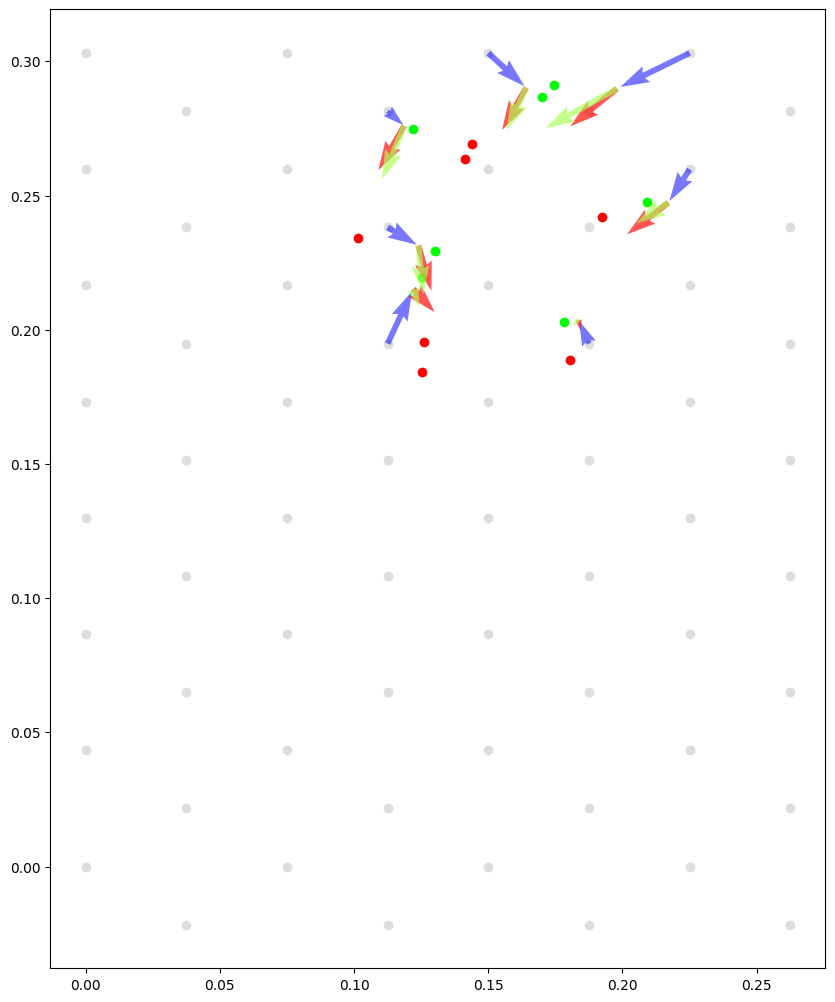

[[ 0.027  -0.0231]
 [ 0.0119  0.0019]
 [ 0.0028 -0.0141]
 [ 0.0217 -0.0251]
 [-0.0205  0.01  ]
 [ 0.0236 -0.0217]
 [ 0.009  -0.0267]]
[[ 0.0248 -0.0184]
 [ 0.0055 -0.0002]
 [ 0.0021 -0.0075]
 [ 0.0143 -0.0241]
 [-0.0204  0.0091]
 [ 0.0236 -0.0171]
 [ 0.0041 -0.0317]]
7


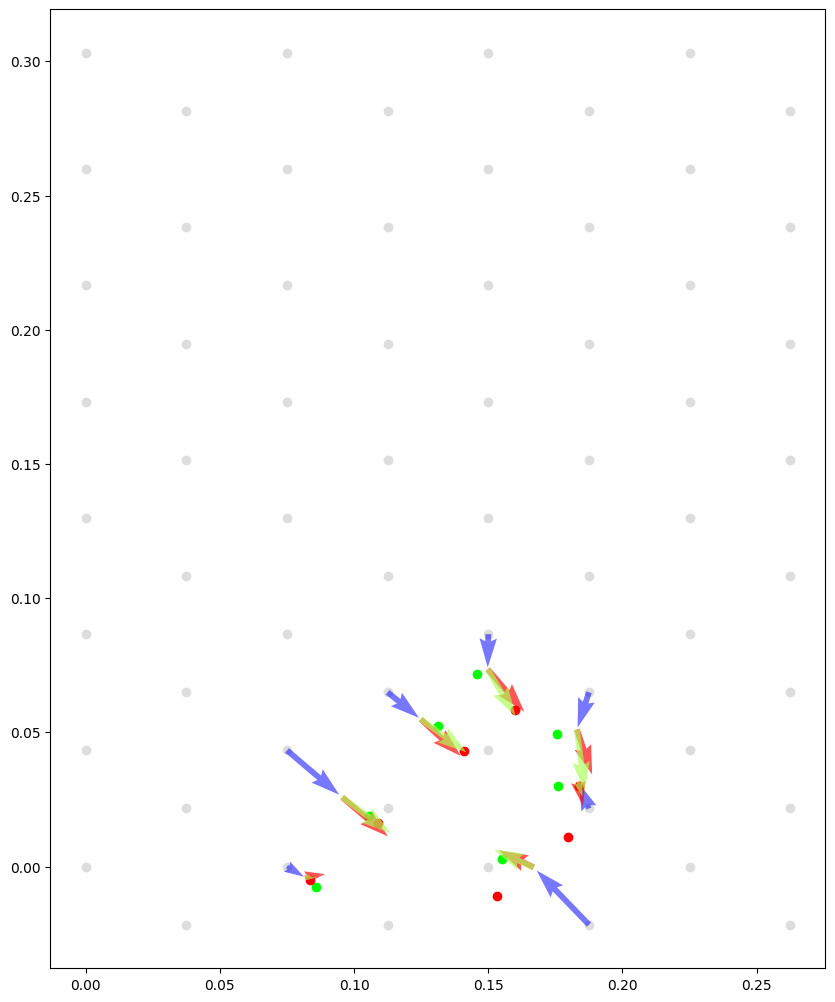

[[-0.0265  0.0283]
 [ 0.0292 -0.028 ]
 [-0.0296 -0.0118]
 [ 0.0297  0.0072]
 [-0.0073 -0.0297]
 [-0.0278 -0.0299]
 [ 0.0288  0.0238]
 [ 0.0046  0.0298]
 [ 0.0283 -0.0297]]
[[-0.0302  0.0442]
 [ 0.045  -0.0355]
 [-0.0572 -0.0072]
 [ 0.0575  0.0068]
 [-0.0195 -0.0562]
 [-0.0412 -0.0674]
 [ 0.0372  0.0264]
 [-0.0031  0.0587]
 [ 0.0459 -0.0694]]
9


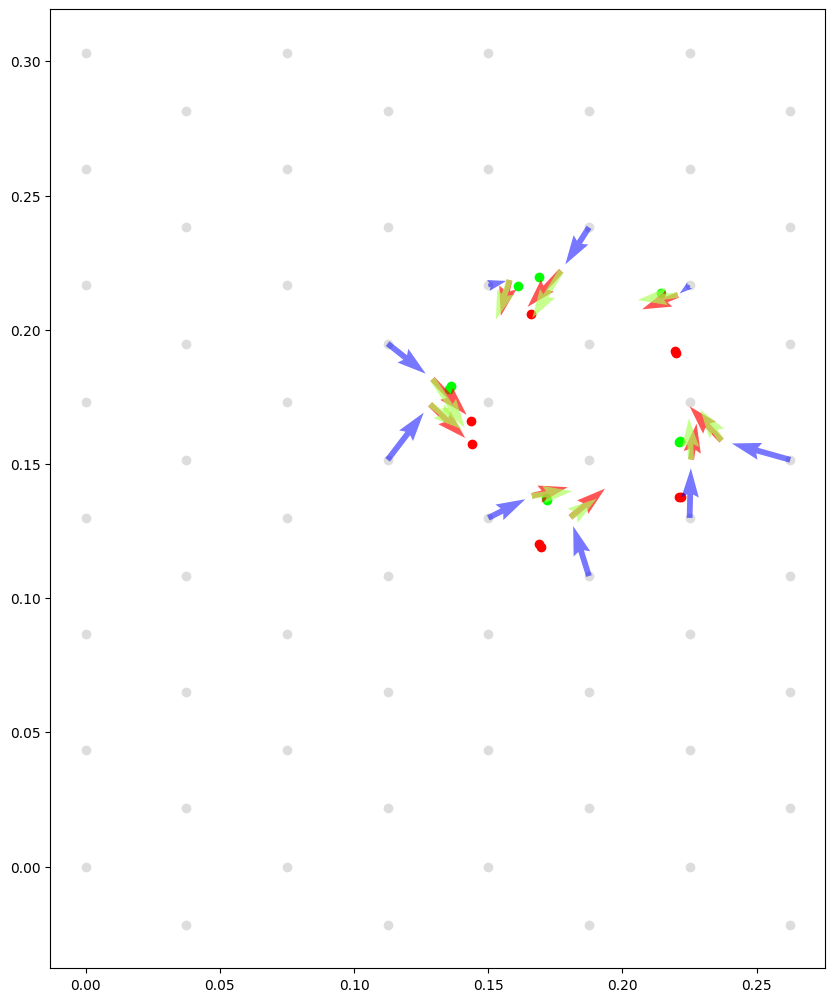

[[ 0.0221  0.0289]
 [-0.0256  0.0134]
 [-0.0279 -0.0151]
 [ 0.0198  0.0103]
 [-0.0249  0.0292]
 [ 0.0239 -0.0206]
 [-0.0232 -0.0271]]
[[ 0.0157  0.037 ]
 [-0.0403  0.0169]
 [-0.0348 -0.0081]
 [ 0.0116  0.0062]
 [-0.0325  0.0382]
 [ 0.0166 -0.0171]
 [-0.0274 -0.033 ]]
7


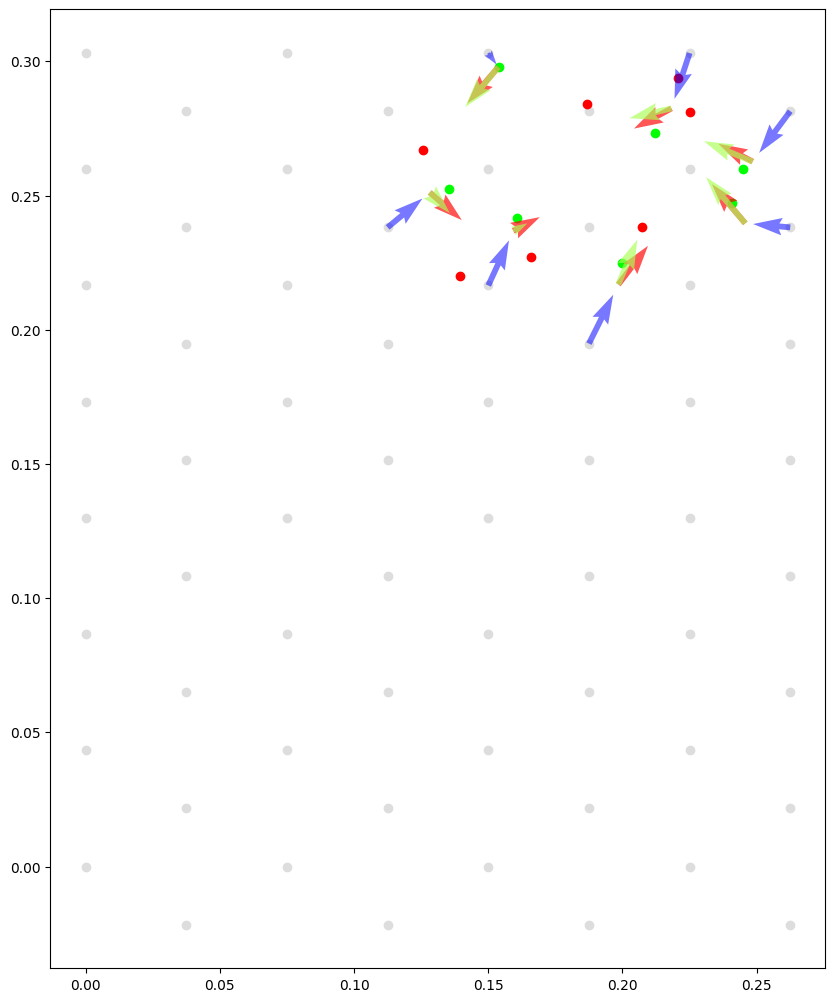

[[-0.0255  0.0297]
 [-0.0042  0.0298]
 [-0.0033 -0.0162]
 [-0.0278  0.0269]
 [ 0.0243  0.0112]
 [-0.0036  0.0249]]
[[-0.0336  0.0391]
 [-0.0151  0.0509]
 [-0.0188 -0.0081]
 [-0.0409  0.0364]
 [ 0.0082  0.0121]
 [-0.0179  0.0266]]
6


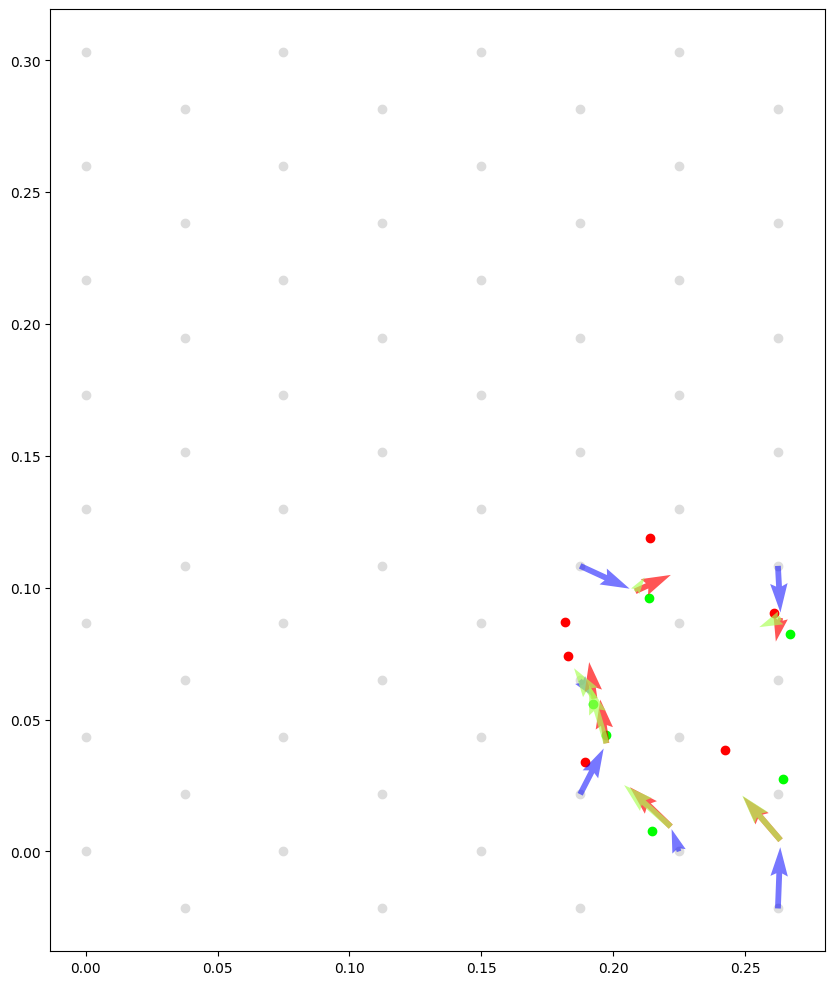

[[ 0.0129  0.0289]
 [ 0.0096 -0.014 ]
 [ 0.0229  0.03  ]
 [-0.0205 -0.016 ]
 [-0.0294  0.0298]
 [-0.0156 -0.0281]
 [ 0.0297  0.0157]]
[[-0.0078  0.0452]
 [-0.0078  0.0011]
 [ 0.0181  0.0775]
 [-0.0225 -0.0041]
 [-0.0546  0.0719]
 [-0.0198 -0.0241]
 [ 0.0626  0.0108]]
7


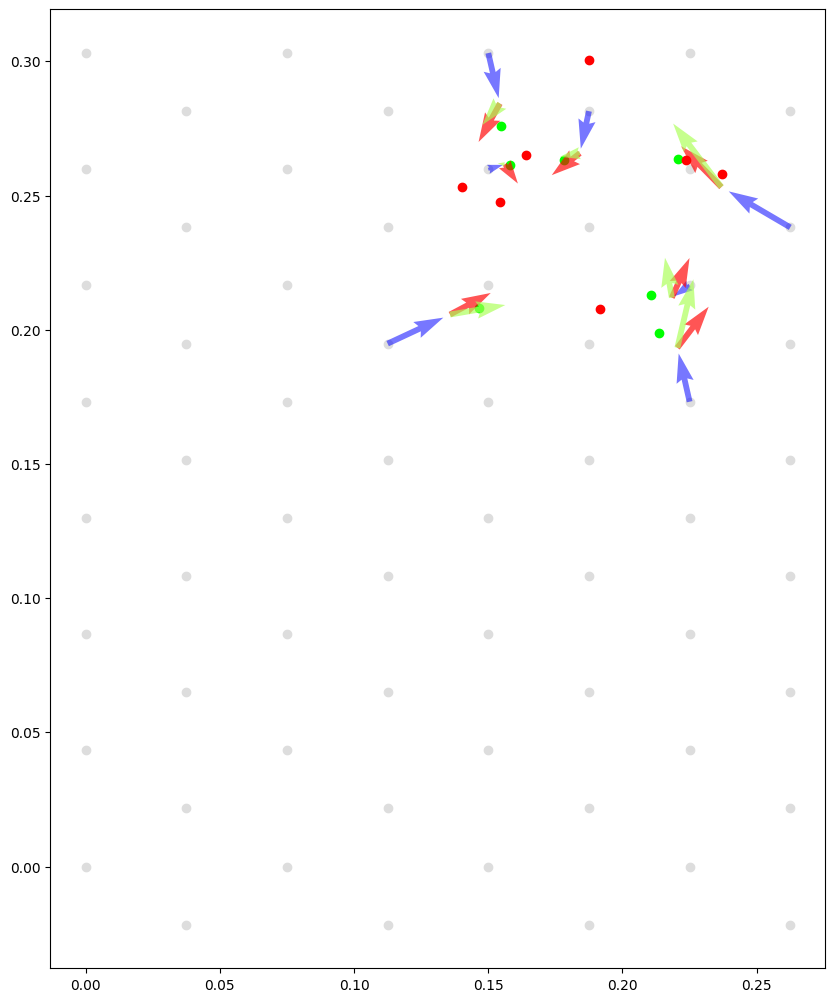

[[ 0.0062 -0.0219]
 [-0.0052 -0.0268]
 [ 0.0146 -0.0151]
 [-0.0234 -0.0211]
 [-0.0242  0.01  ]]
[[ 0.0047 -0.0304]
 [-0.0052 -0.0325]
 [ 0.0058 -0.0188]
 [-0.0281 -0.013 ]
 [-0.0262  0.0071]]
5


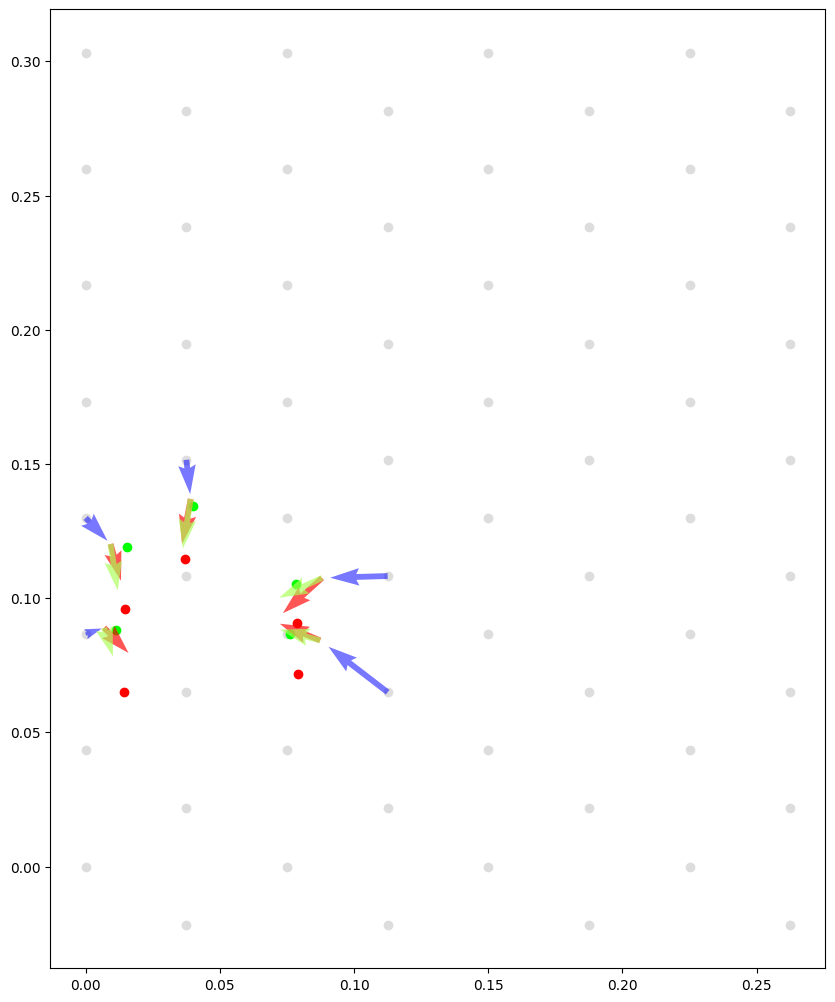

[[-0.0292  0.0264]
 [ 0.0285  0.0292]
 [-0.0237 -0.027 ]
 [ 0.0174  0.0298]
 [-0.0287  0.0079]
 [ 0.0249  0.0187]
 [ 0.0245  0.0228]]
[[-0.0417  0.0202]
 [ 0.0353  0.0526]
 [-0.0285 -0.0316]
 [ 0.0097  0.0522]
 [-0.0389  0.0039]
 [ 0.0178  0.0095]
 [ 0.0177  0.0223]]
7


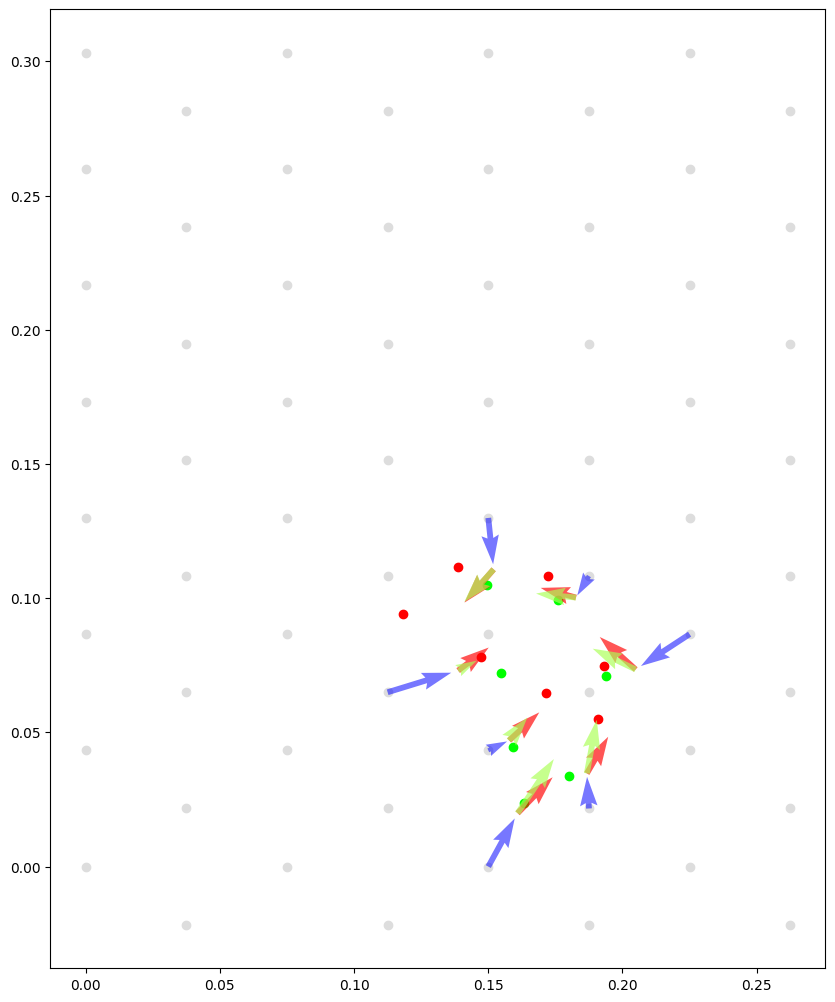

[[-0.0285 -0.0273]
 [ 0.0252  0.002 ]
 [-0.0279  0.0033]
 [ 0.0205  0.0267]
 [ 0.0022 -0.0238]]
[[-0.0368 -0.0332]
 [ 0.0181 -0.0019]
 [-0.0372 -0.0021]
 [ 0.0138  0.0288]
 [-0.0068 -0.029 ]]
5


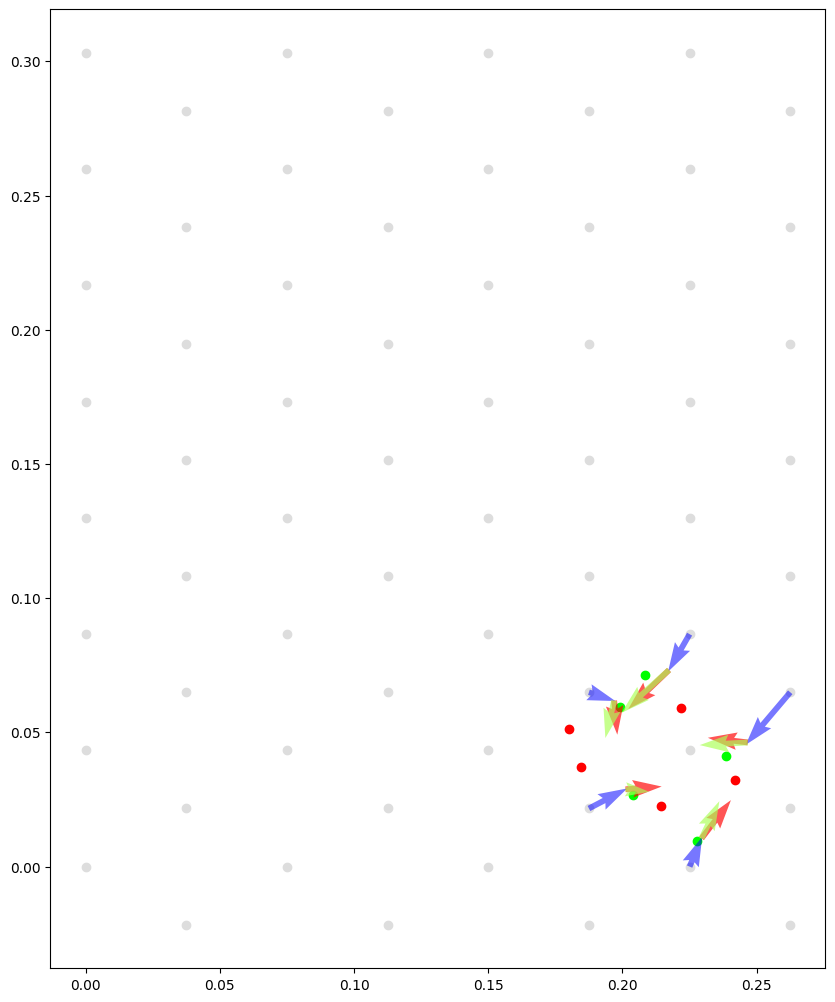

[[ 0.0282 -0.0279]
 [-0.0292  0.0228]
 [ 0.0066  0.0297]
 [ 0.0261  0.0294]]
[[ 0.0286 -0.017 ]
 [-0.046   0.0175]
 [ 0.001   0.0482]
 [ 0.0252  0.0394]]
4


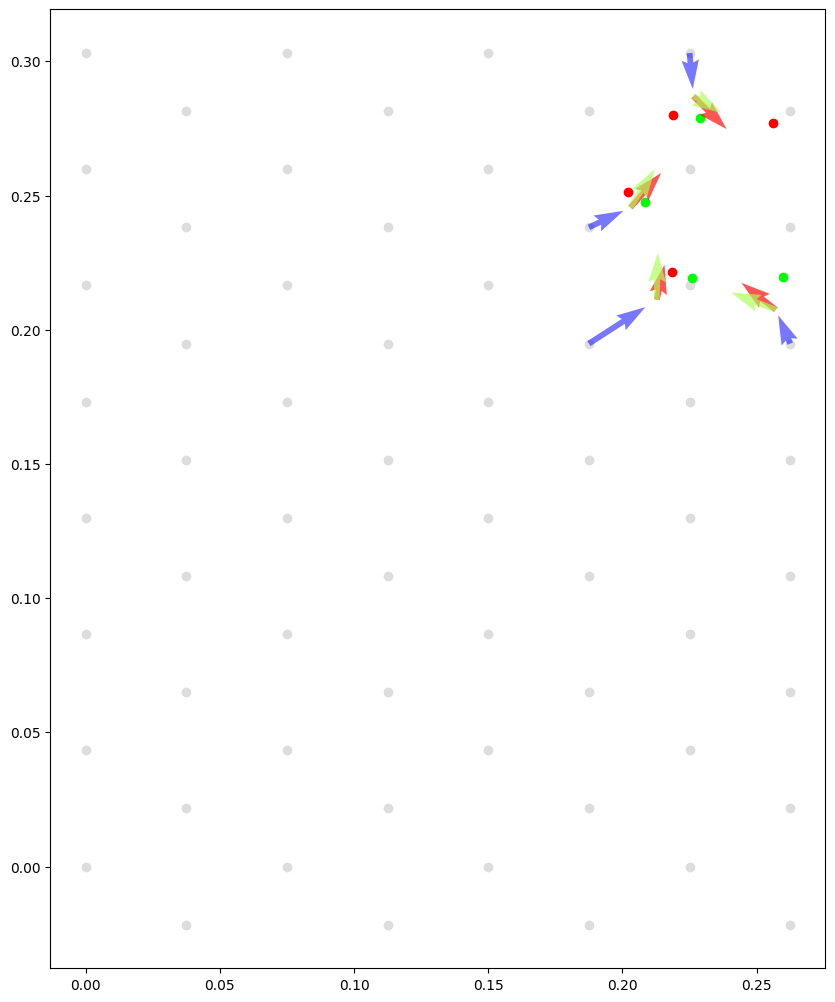

[[-0.0292 -0.0216]
 [-0.0046  0.026 ]
 [ 0.0295 -0.0133]
 [ 0.0285 -0.0272]
 [-0.0254 -0.0295]
 [-0.028   0.0154]]
[[-0.0549 -0.0225]
 [-0.0094  0.0262]
 [ 0.0464 -0.0123]
 [ 0.0388 -0.0367]
 [-0.0363 -0.058 ]
 [-0.0388  0.0088]]
6


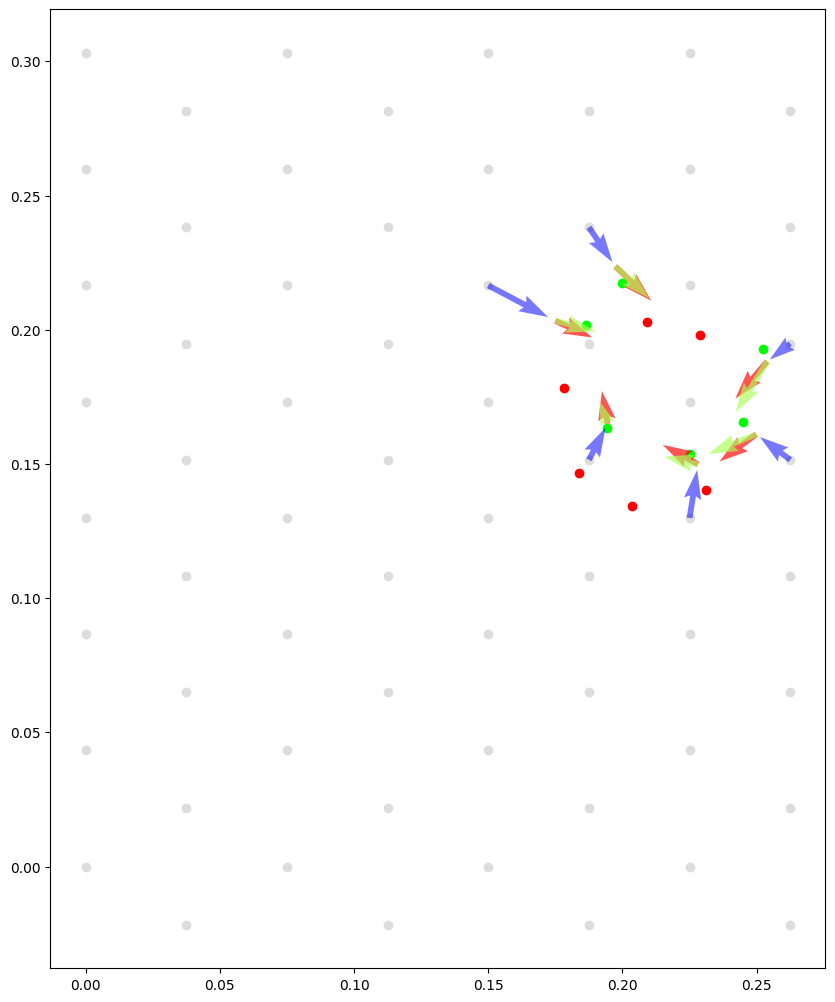

[[ 0.0276  0.0242]
 [-0.0026  0.0253]
 [ 0.0299  0.0161]
 [ 0.0271 -0.0022]
 [ 0.0044  0.028 ]
 [ 0.016   0.0008]
 [-0.0257 -0.0136]]
[[ 0.043   0.0313]
 [-0.0011  0.0216]
 [ 0.0568  0.01  ]
 [ 0.0307 -0.0116]
 [ 0.0016  0.0544]
 [ 0.0107 -0.0076]
 [-0.0219 -0.0105]]
7


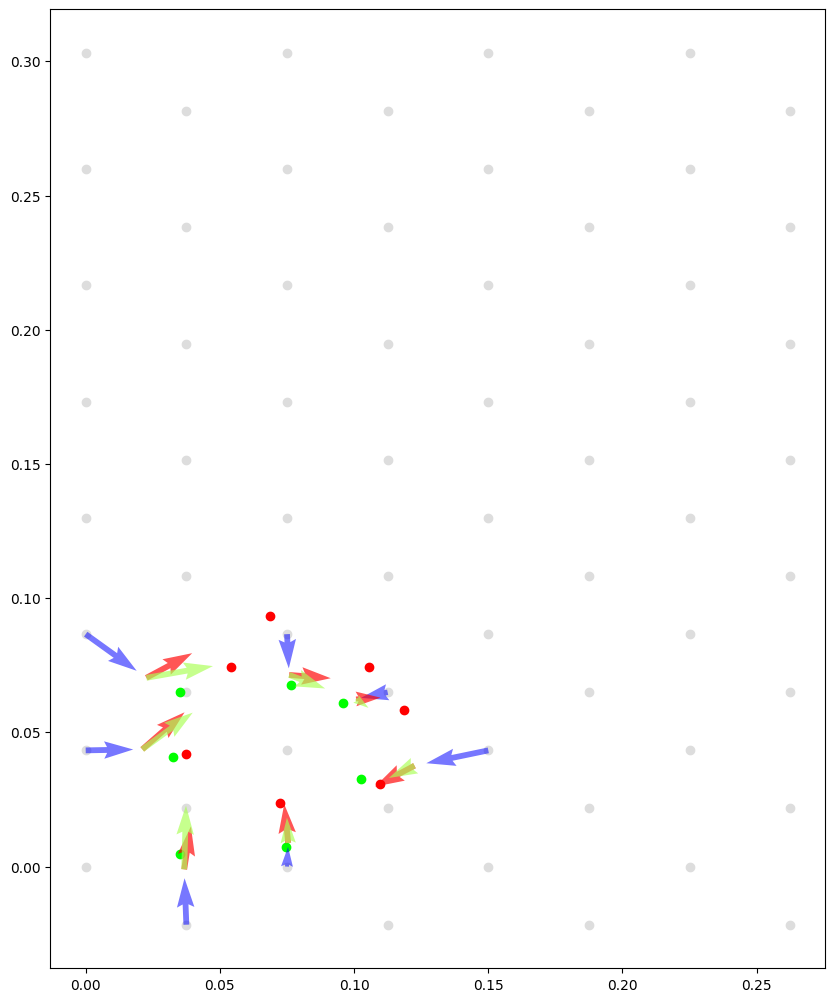

[[ 0.0271  0.0293]
 [-0.0052 -0.0279]
 [-0.0278  0.0296]
 [ 0.0036  0.0298]]
[[ 0.032   0.0407]
 [ 0.002  -0.0406]
 [-0.0328  0.0437]
 [ 0.0035  0.0482]]
4


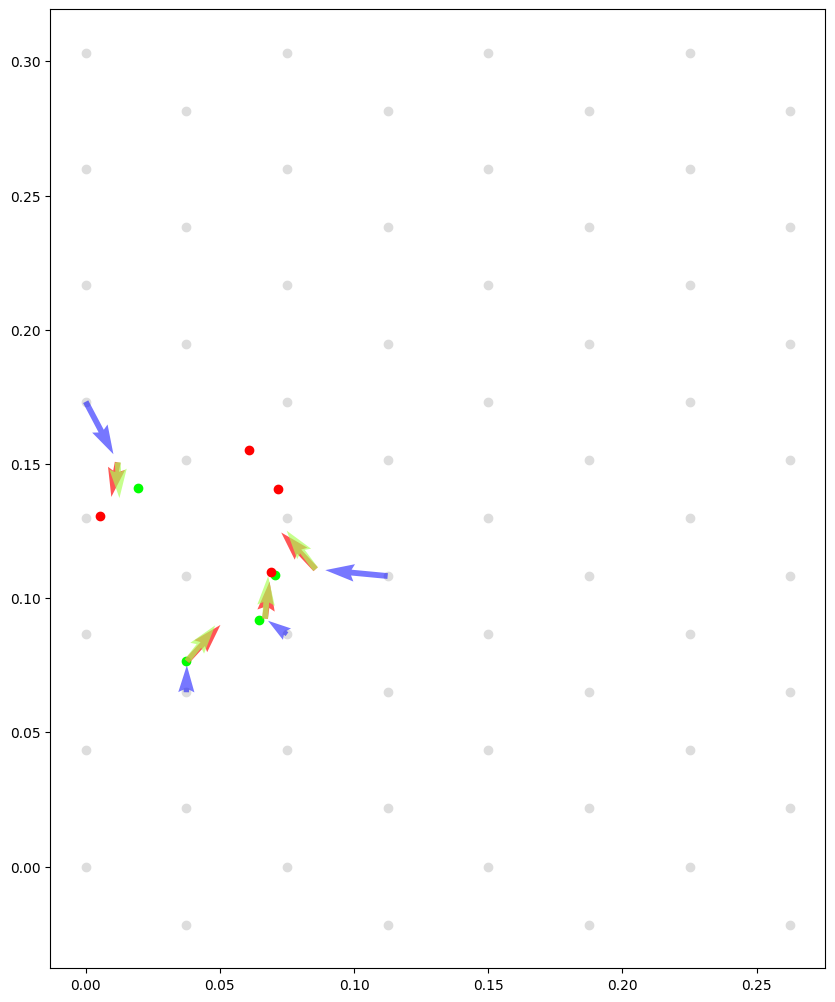

[[-0.0274  0.0165]
 [-0.0286 -0.017 ]
 [ 0.0277 -0.0238]
 [ 0.0294 -0.0054]
 [-0.0222 -0.0294]
 [-0.0129  0.0267]]
[[-0.0361  0.0103]
 [-0.0474 -0.0175]
 [ 0.0352 -0.0293]
 [ 0.0378 -0.0083]
 [-0.0297 -0.0513]
 [-0.0123  0.0214]]
6


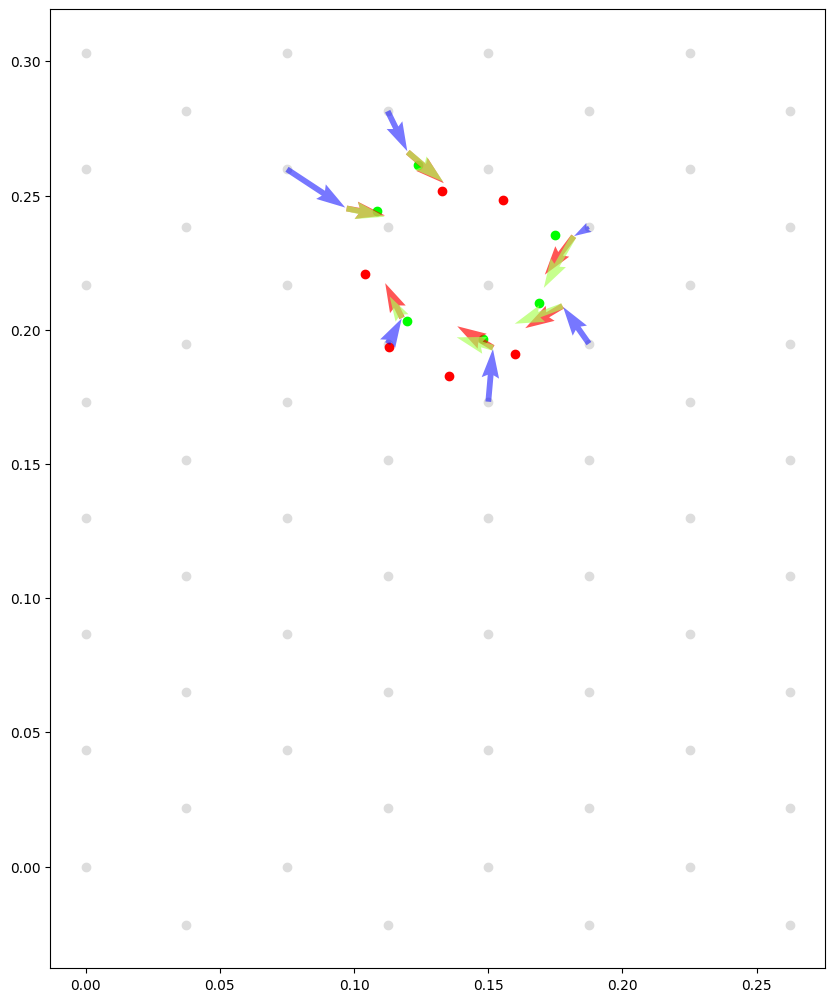

[[-0.0019 -0.0255]
 [-0.024  -0.0235]
 [-0.0097 -0.0174]
 [-0.0263 -0.0256]
 [-0.0019 -0.0118]
 [-0.0245 -0.0197]]
[[-0.011  -0.0165]
 [-0.0305 -0.0162]
 [-0.0165 -0.0035]
 [-0.033  -0.0221]
 [-0.0124  0.0059]
 [-0.0325 -0.0107]]
6


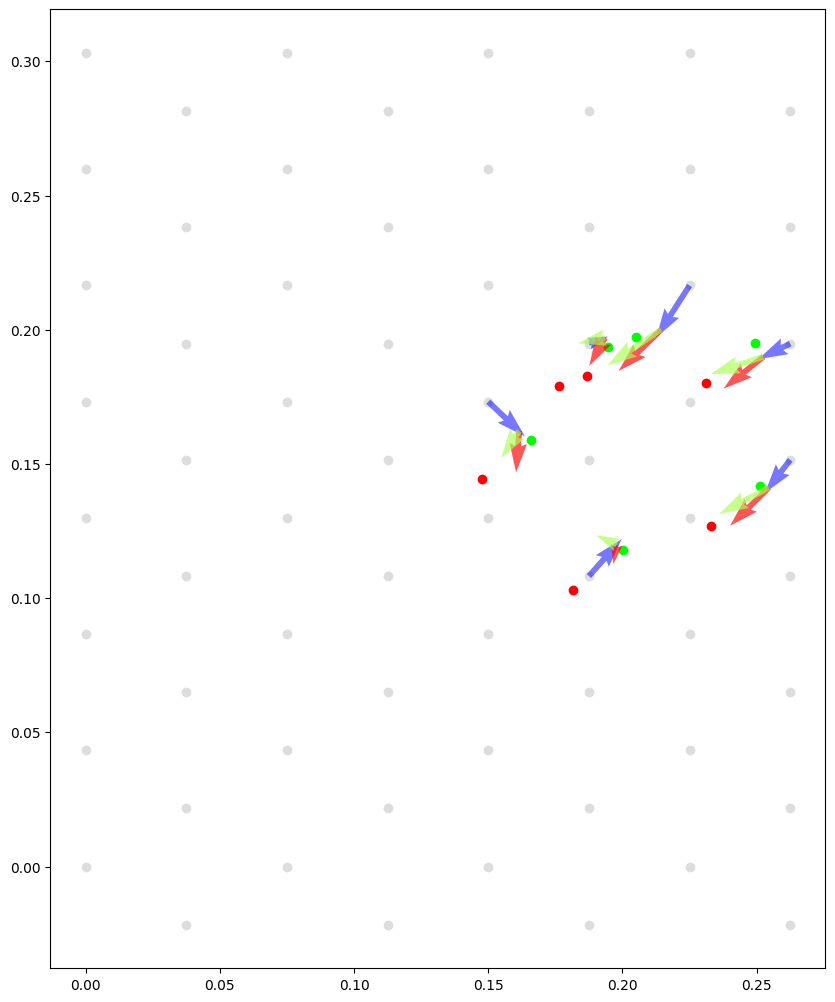

[[ 0.0273 -0.0277]
 [ 0.0149 -0.025 ]
 [ 0.0295  0.0038]
 [ 0.0239 -0.0175]
 [ 0.0245  0.0115]
 [-0.0134 -0.0227]
 [-0.0225  0.017 ]]
[[ 0.0338 -0.0326]
 [ 0.0146 -0.0227]
 [ 0.0432 -0.0035]
 [ 0.0281 -0.0183]
 [ 0.0237  0.0069]
 [-0.0095 -0.0166]
 [-0.019   0.0089]]
7


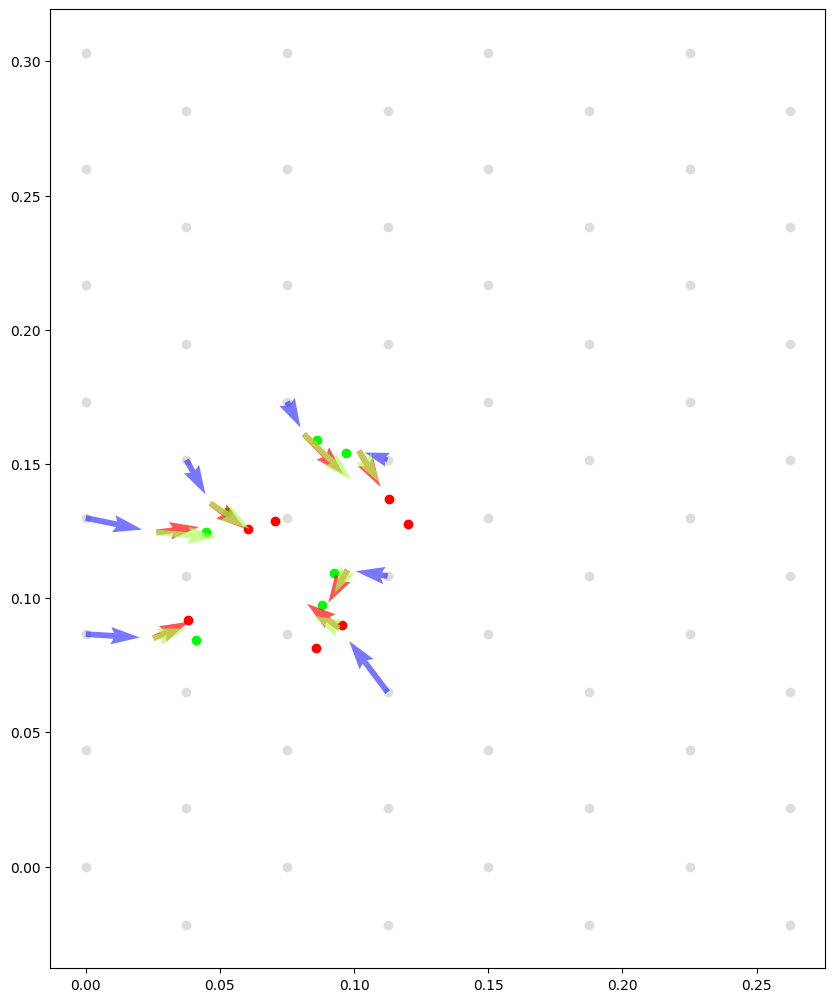

[[ 0.0148 -0.0253]
 [-0.029   0.0281]
 [ 0.0121  0.0296]
 [-0.0238 -0.024 ]
 [ 0.0242 -0.004 ]
 [-0.0247  0.0295]]
[[ 0.0099 -0.0284]
 [-0.0446  0.0371]
 [ 0.0061  0.0566]
 [-0.0261 -0.0223]
 [ 0.0221 -0.0037]
 [-0.0284  0.0599]]
6


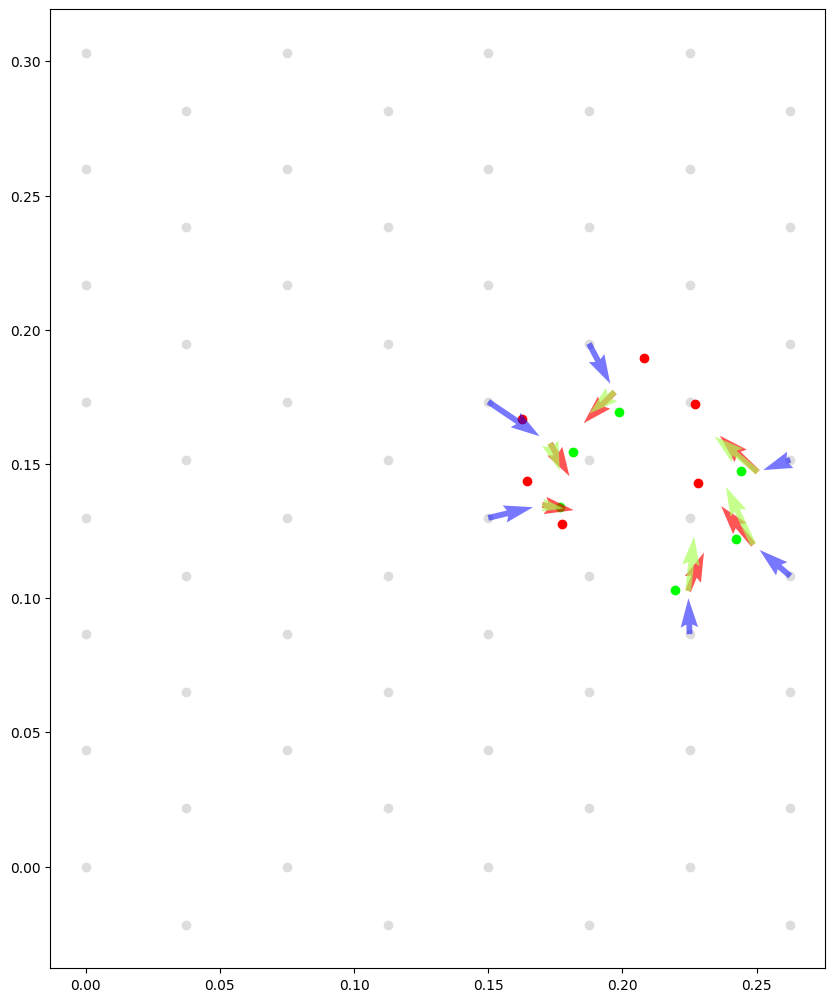

[[-0.0287 -0.0296]
 [-0.0269 -0.0297]
 [ 0.0287  0.0105]
 [-0.0297 -0.0225]
 [ 0.0059 -0.0289]
 [-0.0258 -0.0108]
 [ 0.0273 -0.0253]
 [ 0.0091  0.0179]]
[[-0.0497 -0.0578]
 [-0.0329 -0.0613]
 [ 0.0469  0.0015]
 [-0.0674 -0.0234]
 [-0.0025 -0.0432]
 [-0.036  -0.0037]
 [ 0.0317 -0.026 ]
 [-0.0021  0.0143]]
8


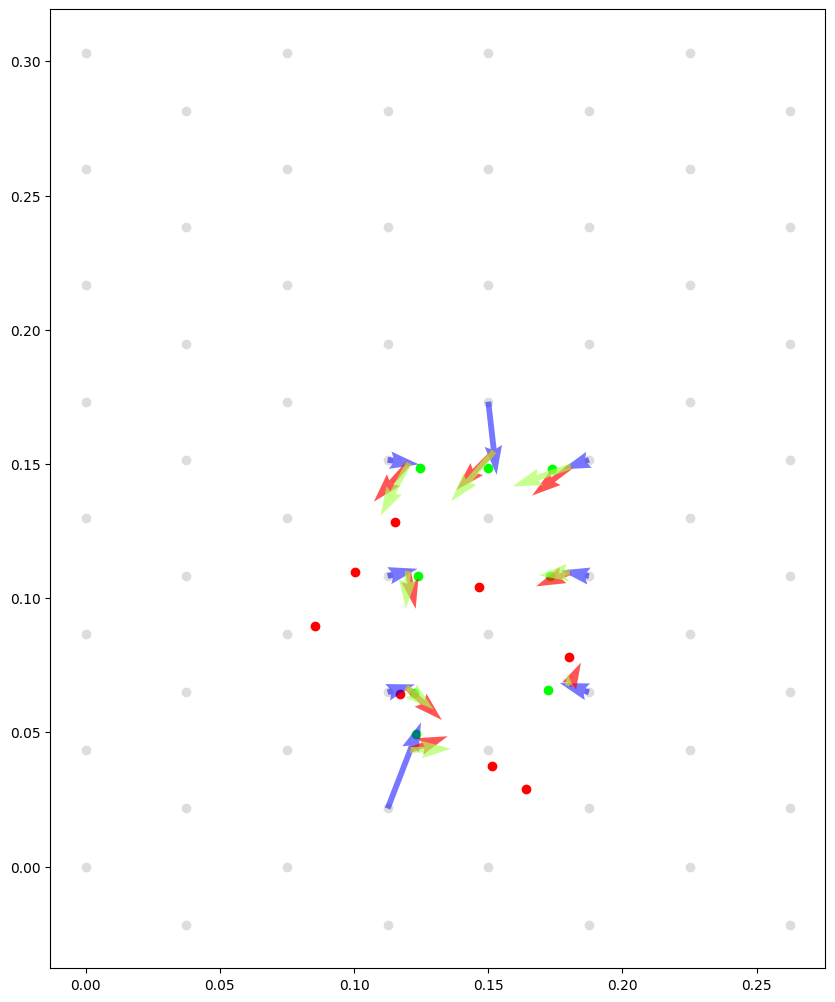

[[ 0.0299 -0.0061]
 [ 0.0296  0.0213]
 [-0.0298  0.0098]
 [-0.0264 -0.0298]
 [ 0.0292 -0.0298]
 [-0.0289 -0.0233]
 [-0.0178  0.0287]]
[[ 0.0722 -0.0042]
 [ 0.0425  0.0159]
 [-0.0718  0.0155]
 [-0.0476 -0.0695]
 [ 0.0461 -0.0781]
 [-0.042  -0.0138]
 [-0.0152  0.0304]]
7


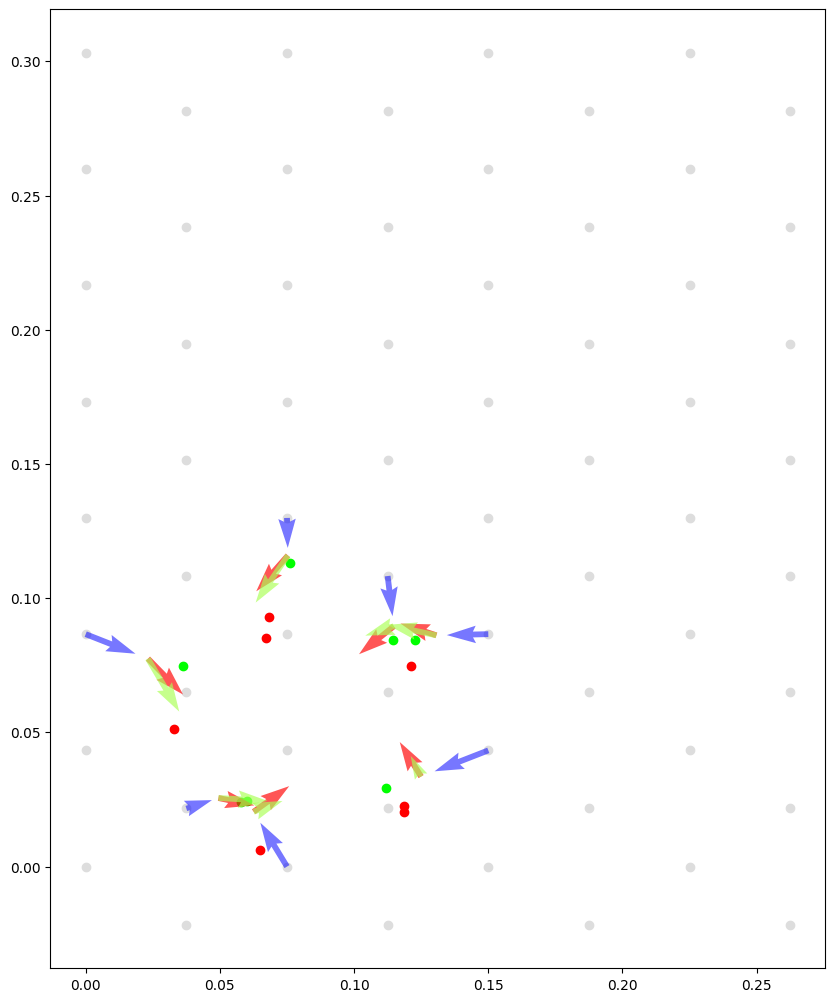

[[ 0.0282  0.0295]
 [ 0.0297  0.0125]
 [-0.0136  0.0286]
 [-0.0084 -0.0151]
 [ 0.0294 -0.0205]
 [ 0.0046  0.015 ]
 [ 0.0229 -0.0263]]
[[ 0.0355  0.0543]
 [ 0.0601  0.0194]
 [-0.0189  0.0391]
 [-0.0064 -0.0099]
 [ 0.0468 -0.0187]
 [ 0.003   0.0162]
 [ 0.025  -0.0313]]
7


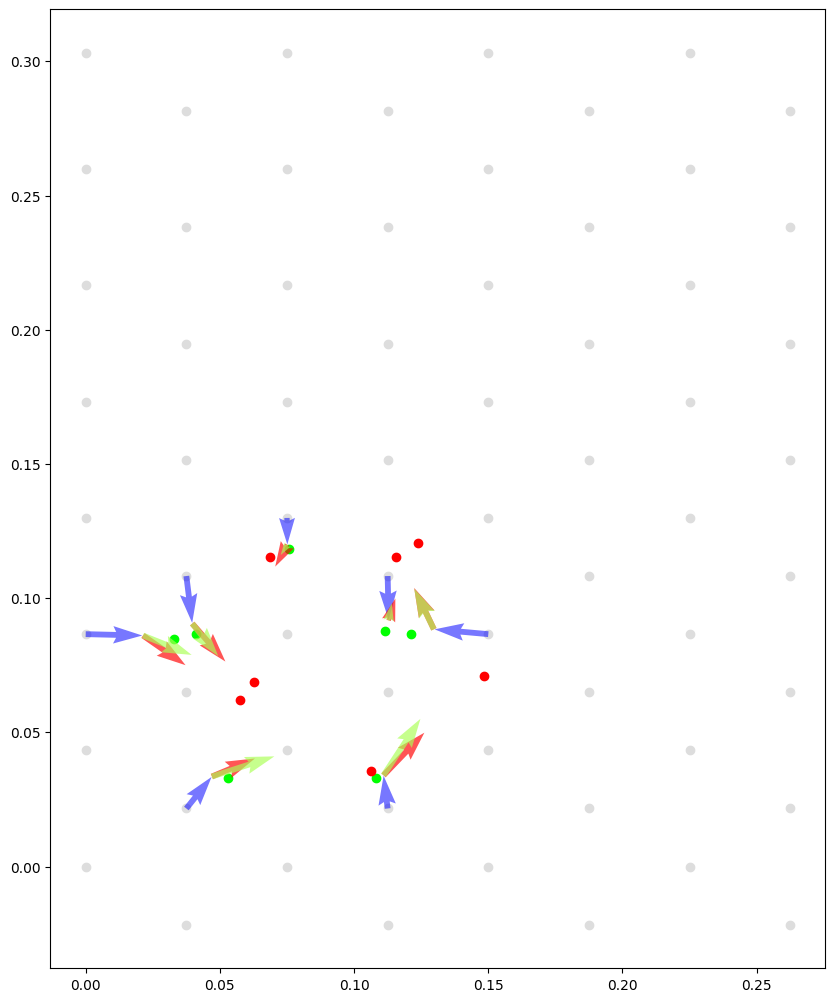

[[ 0.0233 -0.0018]
 [ 0.0048 -0.0289]
 [ 0.0017 -0.0197]
 [ 0.0233 -0.0267]
 [ 0.0287 -0.0131]]
[[ 0.0263 -0.0067]
 [-0.002  -0.0461]
 [-0.0011 -0.0183]
 [ 0.0196 -0.0288]
 [ 0.0413 -0.0154]]
5


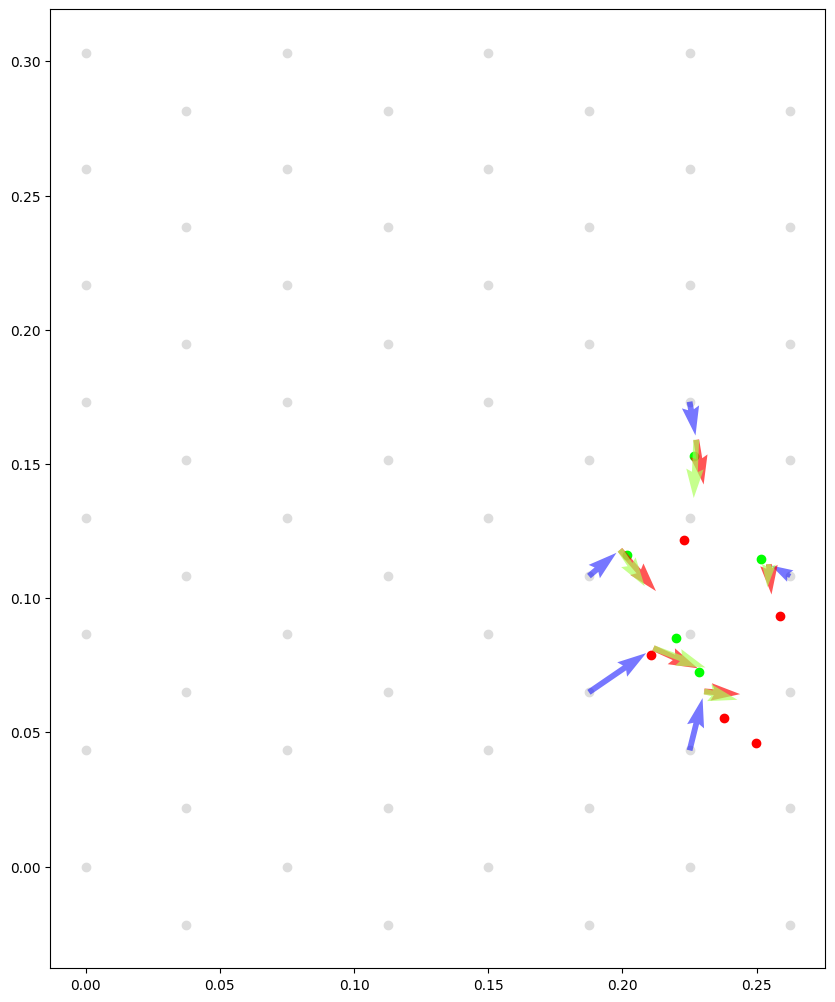

[[ 0.0118 -0.0189]
 [-0.0199 -0.0294]
 [-0.0229  0.0276]
 [-0.0299  0.0271]]
[[-0.0023 -0.0298]
 [-0.0213 -0.057 ]
 [-0.025   0.0429]
 [-0.0787  0.0353]]
4


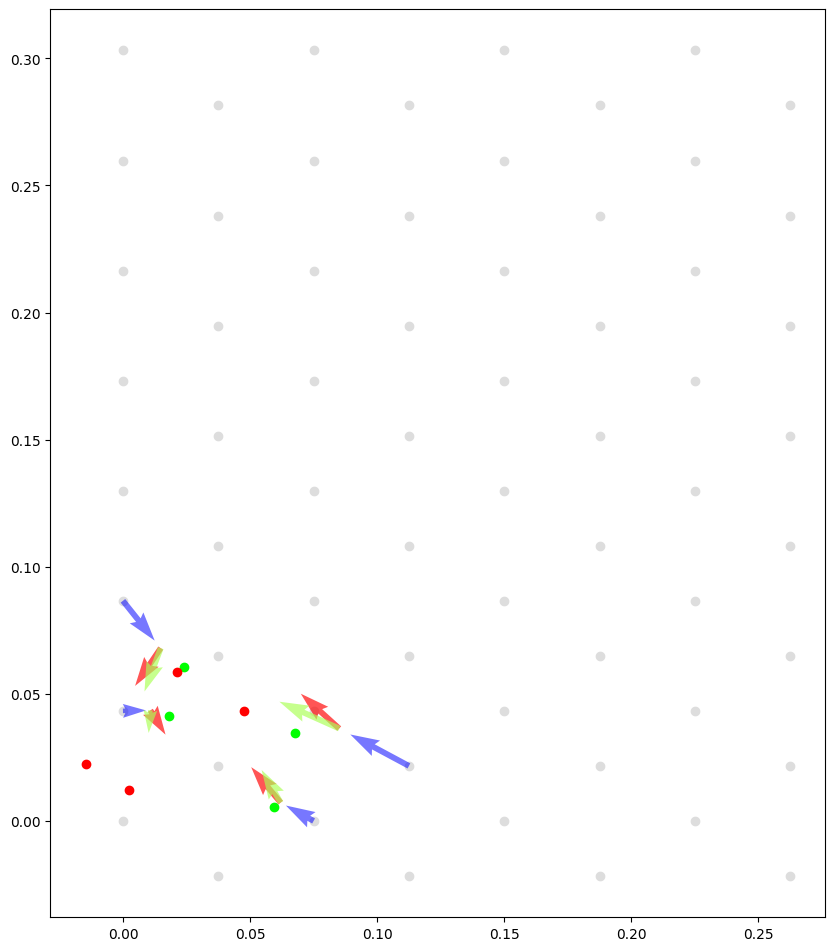

[[-0.0297 -0.0228]
 [-0.0299  0.0268]
 [ 0.0287 -0.0274]
 [-0.0239 -0.0296]
 [ 0.0185  0.0277]
 [-0.0296 -0.0297]
 [ 0.0061 -0.0299]]
[[-0.0607 -0.0175]
 [-0.0852  0.0356]
 [ 0.0414 -0.0374]
 [-0.0338 -0.0581]
 [ 0.0086  0.0379]
 [-0.0701 -0.0662]
 [-0.0021 -0.0789]]
7


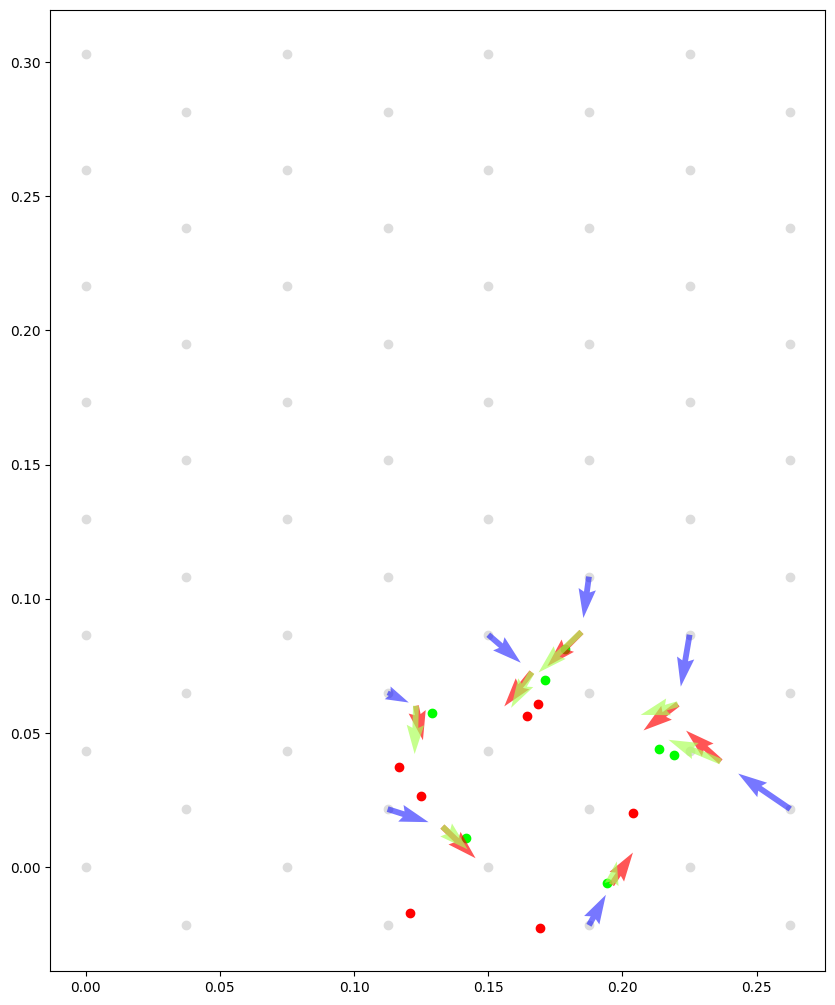

[[ 0.0269  0.0223]
 [ 0.0289 -0.005 ]
 [ 0.0079 -0.0181]
 [ 0.0286 -0.0222]
 [ 0.0105  0.0226]
 [ 0.0148  0.0109]]
[[ 0.0365  0.0202]
 [ 0.0381 -0.0145]
 [ 0.0166 -0.025 ]
 [ 0.0515 -0.0264]
 [ 0.0112  0.0123]
 [ 0.0173  0.0071]]
6


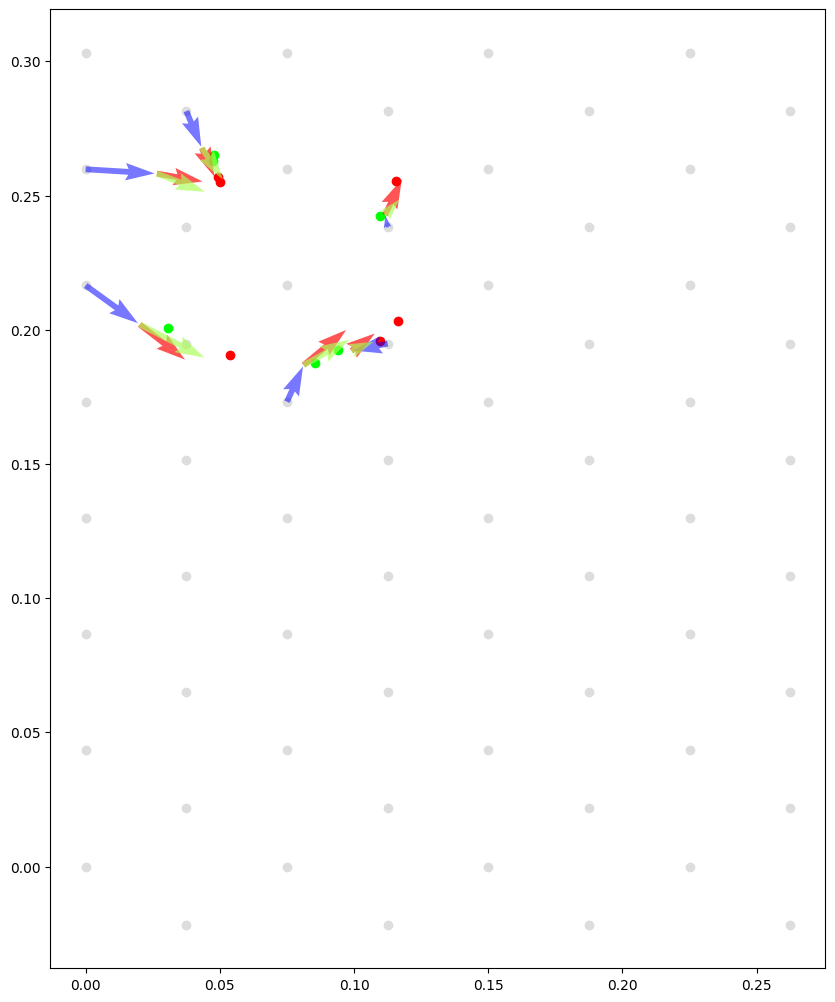

[[-0.0286  0.0129]
 [-0.0203 -0.0022]
 [ 0.0285 -0.0164]
 [ 0.0237 -0.0022]
 [-0.0152 -0.029 ]
 [ 0.017   0.0289]]
[[-0.0366  0.0135]
 [-0.0204 -0.0085]
 [ 0.0401 -0.0206]
 [ 0.0231  0.0044]
 [-0.0149 -0.04  ]
 [ 0.0169  0.0332]]
6


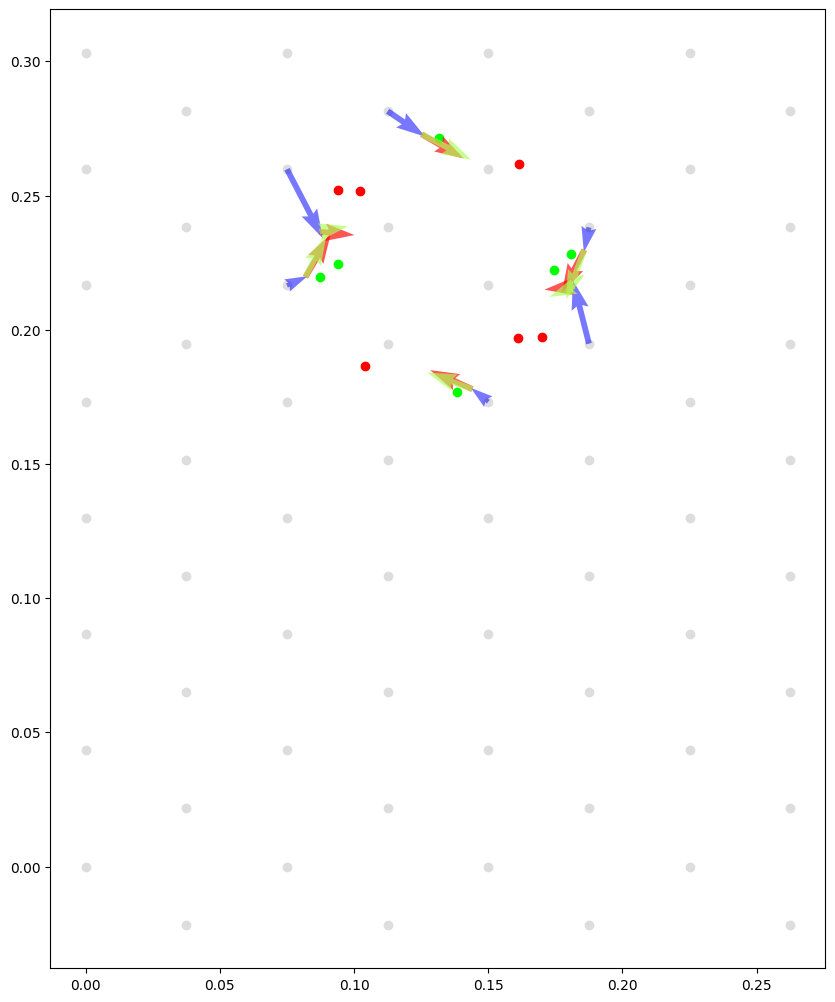

[[ 0.0287 -0.0287]
 [-0.0193  0.0258]
 [ 0.0074 -0.0279]
 [ 0.0282 -0.0114]
 [-0.0255 -0.0126]
 [ 0.0187  0.0089]]
[[ 0.041  -0.0496]
 [-0.0175  0.0205]
 [ 0.0053 -0.0404]
 [ 0.0347 -0.0076]
 [-0.0251 -0.0088]
 [ 0.0078  0.0095]]
6


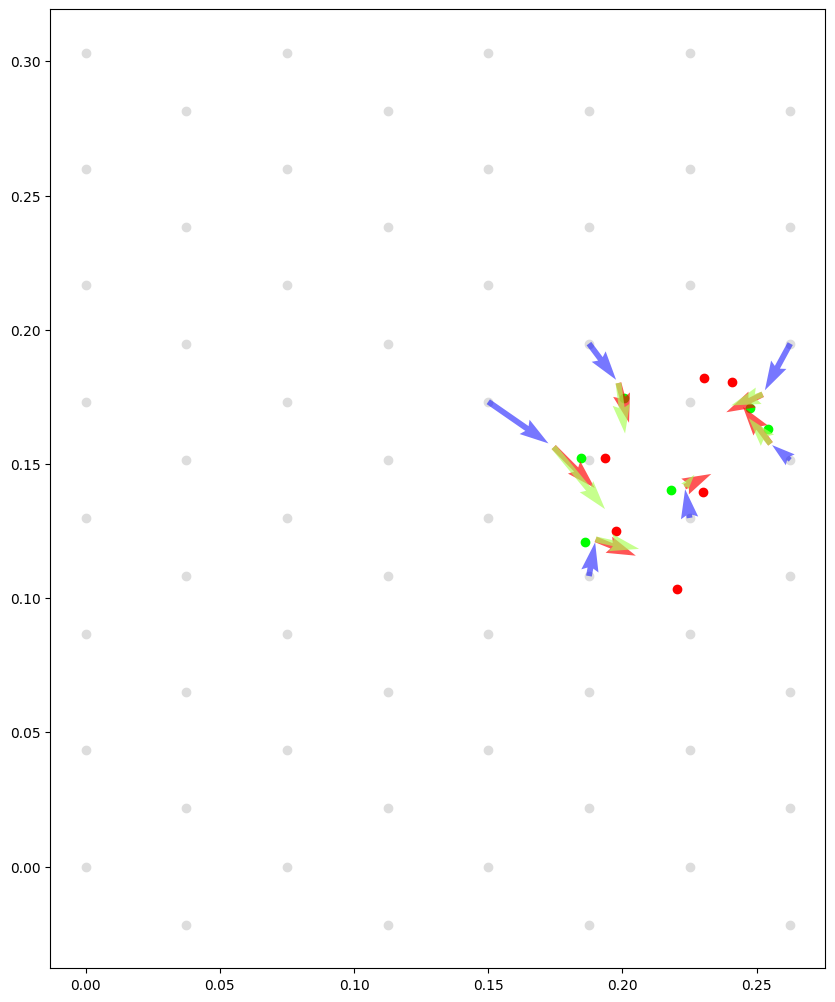

[[-0.0293 -0.0246]
 [ 0.0285  0.0299]
 [-0.0068  0.0298]
 [ 0.0204 -0.03  ]
 [ 0.0293 -0.0169]
 [ 0.028  -0.0298]
 [-0.0271  0.0299]
 [-0.0287 -0.0298]]
[[-0.0593 -0.0289]
 [ 0.0494  0.0707]
 [-0.0109  0.0672]
 [ 0.016  -0.0986]
 [ 0.0421 -0.0098]
 [ 0.0367 -0.0645]
 [-0.0456  0.078 ]
 [-0.0545 -0.0742]]
8


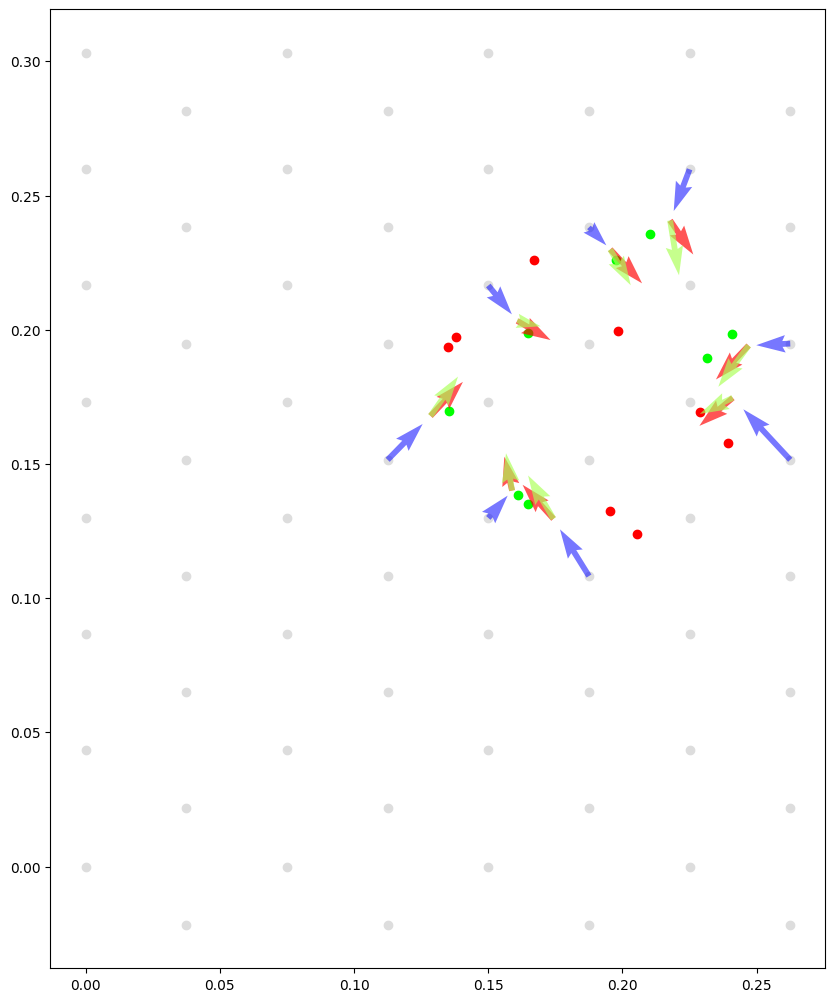

[[ 0.0275 -0.0184]
 [-0.0088  0.0269]
 [ 0.0283  0.0223]
 [ 0.0099  0.0287]
 [ 0.0218 -0.001 ]
 [ 0.0121  0.0139]]
[[ 0.0299 -0.013 ]
 [-0.0128  0.0328]
 [ 0.0317  0.0217]
 [ 0.0054  0.039 ]
 [ 0.0176 -0.0004]
 [ 0.0043  0.0114]]
6


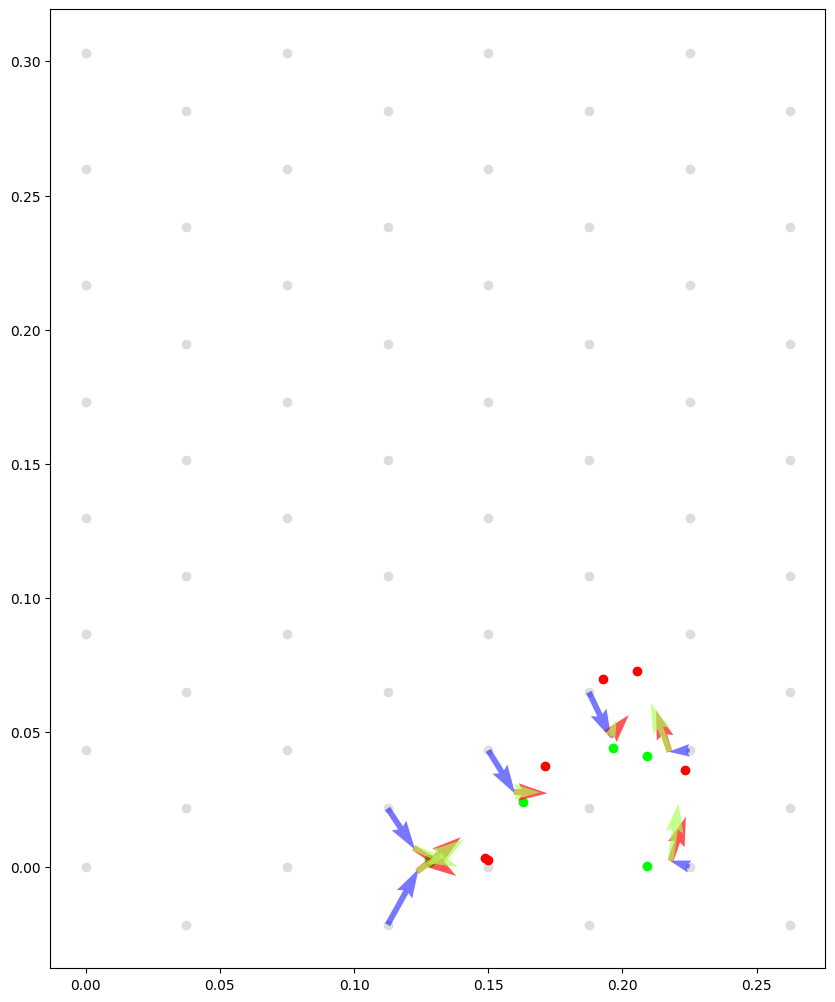

[[ 0.0295 -0.0138]
 [-0.0167 -0.0292]
 [ 0.0237 -0.0047]
 [-0.0291 -0.0252]
 [-0.0273  0.0275]]
[[ 0.042  -0.0227]
 [-0.0191 -0.0475]
 [ 0.0114 -0.0053]
 [-0.0495 -0.0282]
 [-0.0361  0.027 ]]
5


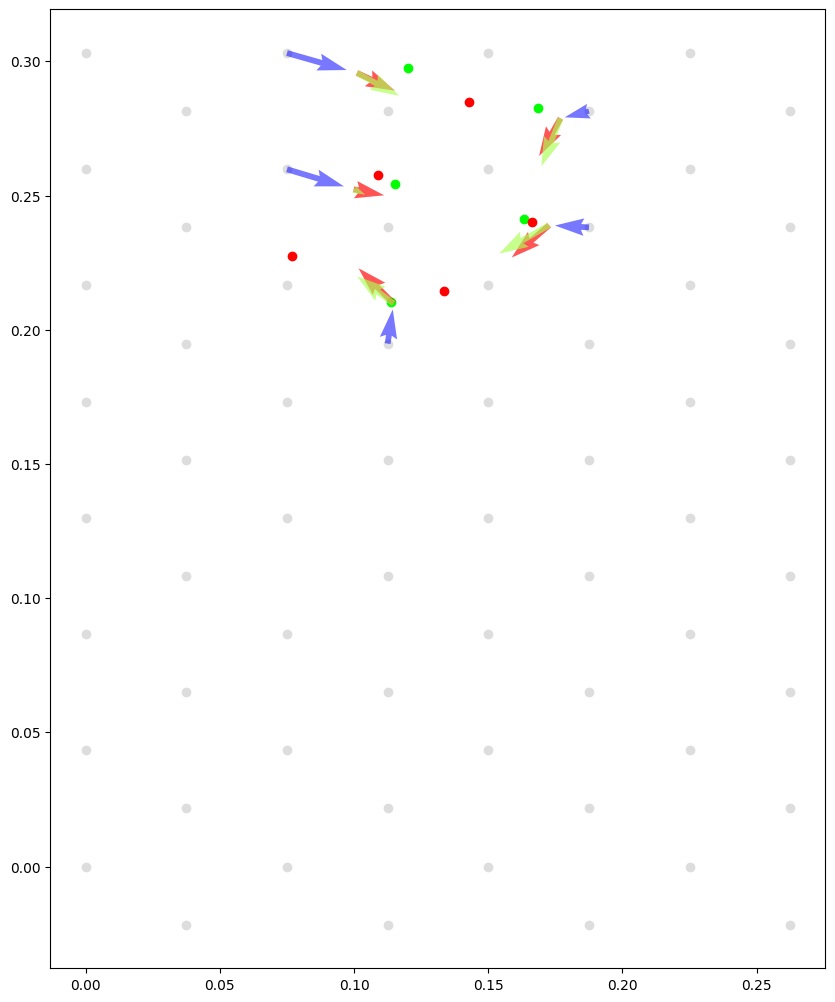

[[ 0.0292 -0.0217]
 [ 0.0288 -0.0114]
 [ 0.0246 -0.0135]
 [ 0.0081 -0.007 ]
 [ 0.0237  0.0276]
 [ 0.0297  0.0288]
 [-0.02    0.0123]]
[[ 0.0421 -0.0189]
 [ 0.0432 -0.0005]
 [ 0.0252 -0.0084]
 [ 0.0018  0.0011]
 [ 0.0244  0.0326]
 [ 0.0587  0.0438]
 [-0.0191  0.0138]]
7


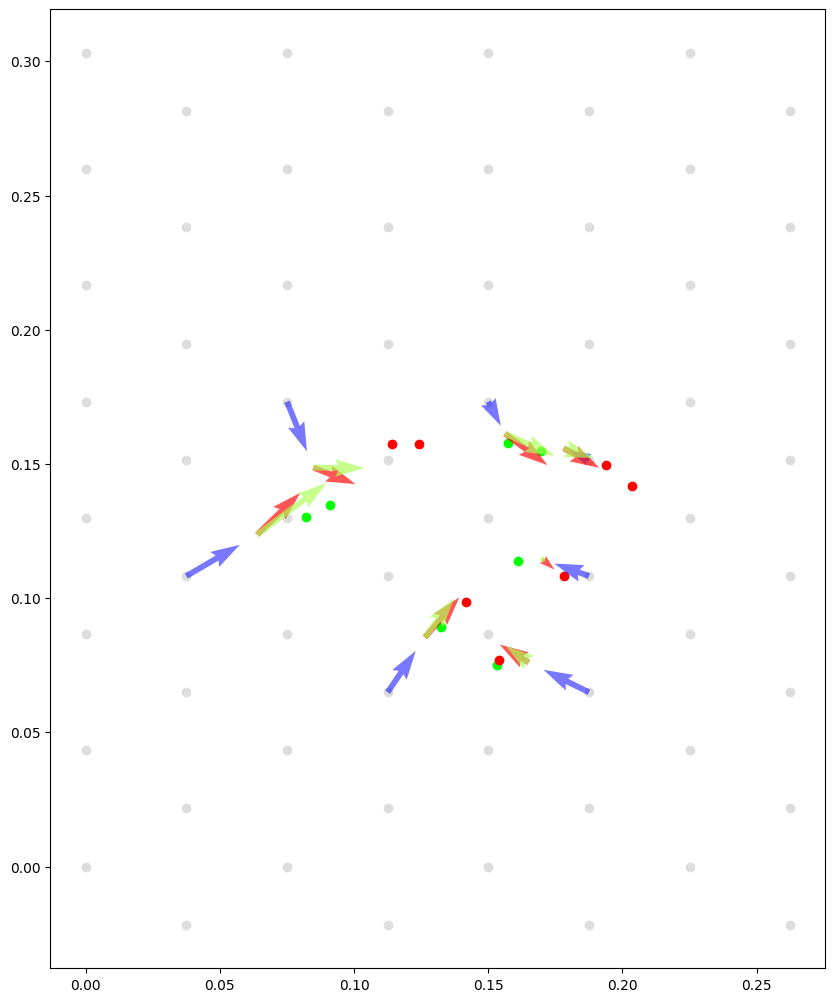

[[-0.0065  0.0298]
 [ 0.0243 -0.0033]
 [-0.0137 -0.0294]
 [-0.0244 -0.0247]
 [ 0.0026 -0.0144]]
[[-0.004   0.0368]
 [ 0.0097 -0.0081]
 [-0.0294 -0.0457]
 [-0.0294 -0.0213]
 [-0.0145 -0.0114]]
5


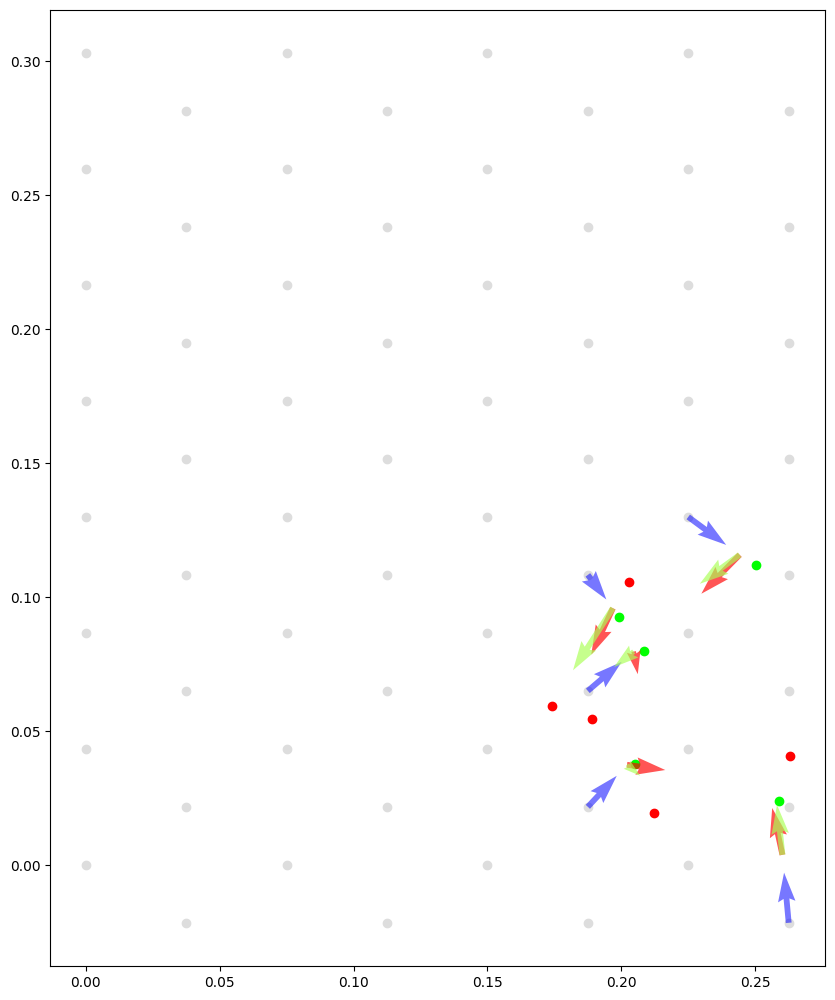

[[ 0.0193  0.0283]
 [ 0.0258  0.0261]
 [ 0.0277  0.0126]
 [ 0.0243  0.0231]
 [-0.0083  0.0159]]
[[ 0.0076  0.0375]
 [ 0.0091  0.0311]
 [ 0.0221  0.0119]
 [ 0.0129  0.0169]
 [-0.0131  0.0125]]
5


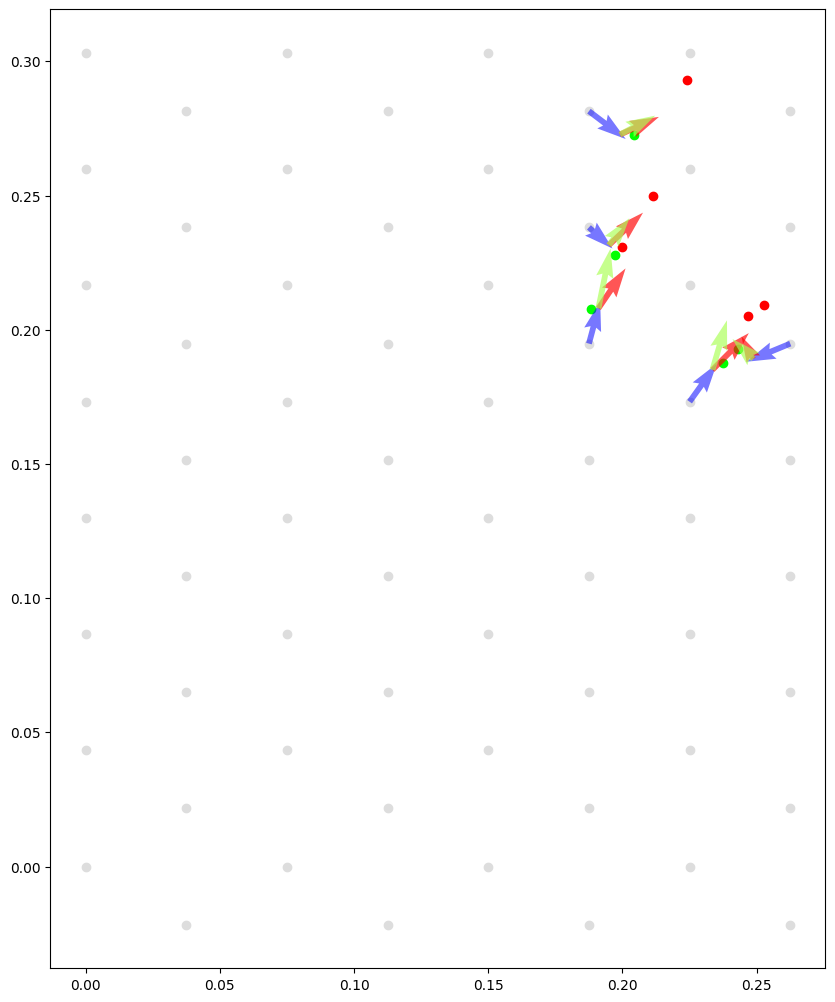

[[-0.029   0.0213]
 [-0.026  -0.0061]
 [-0.0202  0.0297]
 [ 0.0294  0.0292]
 [-0.0009 -0.0291]
 [ 0.0223  0.0296]]
[[-0.0327  0.017 ]
 [-0.0208 -0.0029]
 [-0.0179  0.0549]
 [ 0.0503  0.0412]
 [-0.0011 -0.0375]
 [ 0.0274  0.0484]]
6


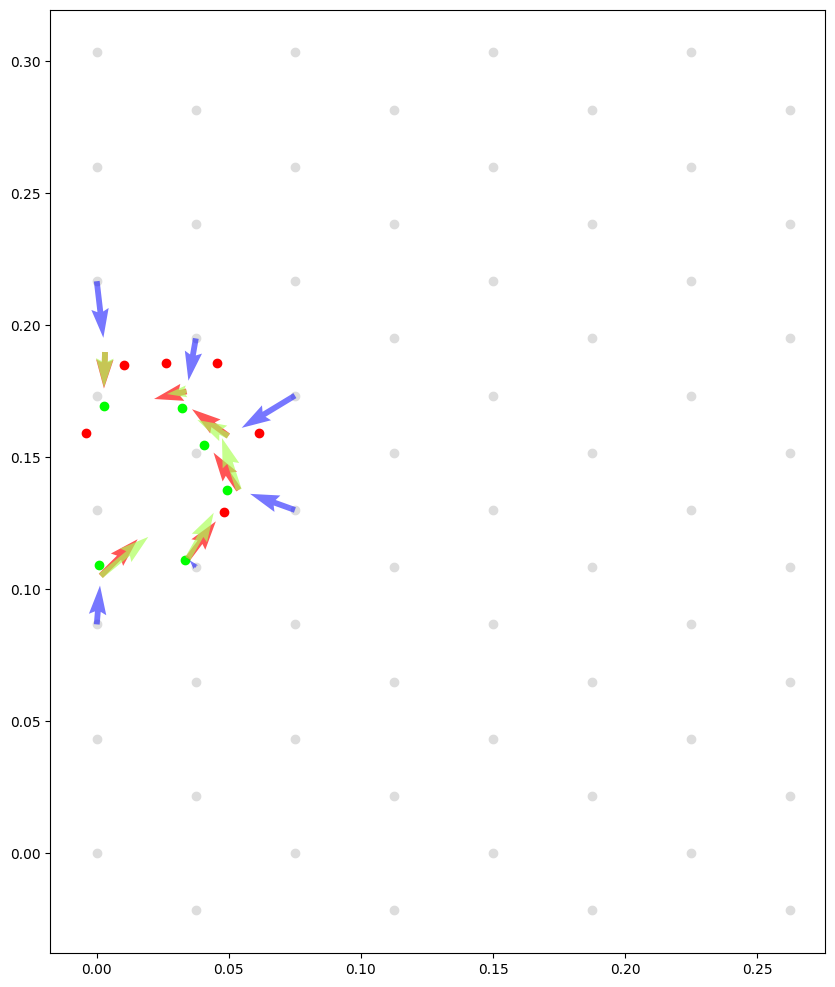

[[ 0.0272  0.0244]
 [ 0.0282 -0.0105]
 [-0.0121  0.0159]
 [ 0.0209 -0.0196]]
[[ 0.0376  0.0229]
 [ 0.0407 -0.0105]
 [ 0.0046  0.0235]
 [ 0.0124 -0.0087]]
4


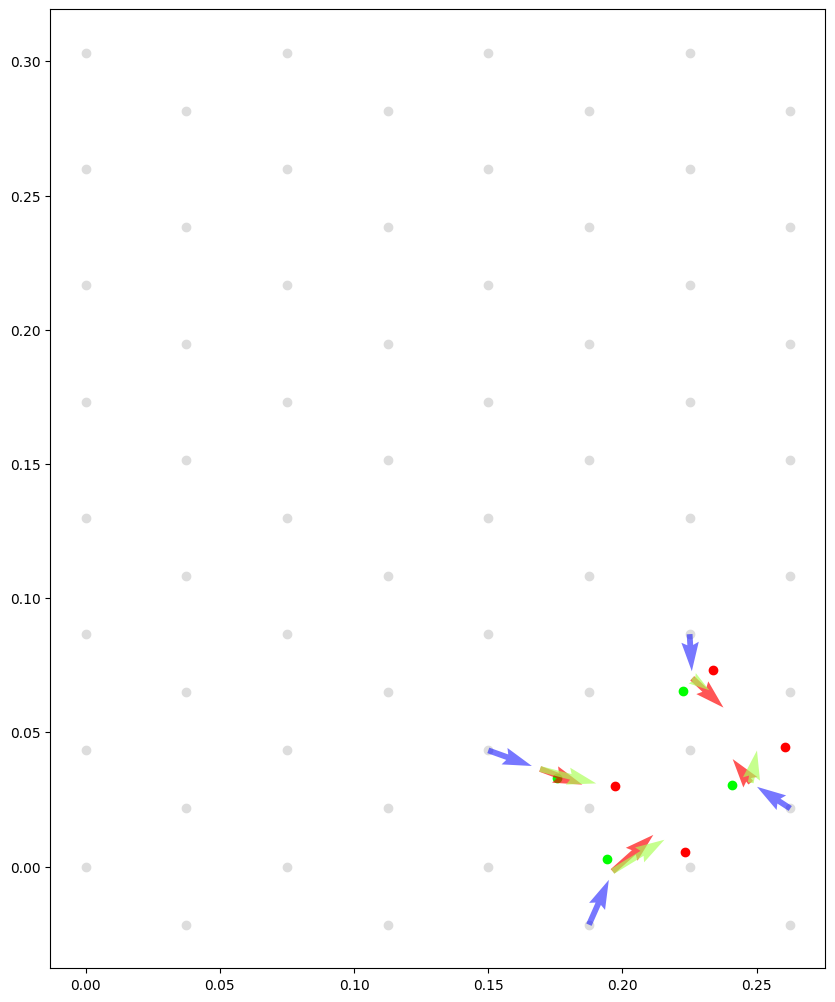

[[-0.029  -0.0055]
 [-0.0274  0.0234]
 [-0.0023  0.0006]
 [ 0.0136  0.0272]
 [ 0.0104  0.0291]
 [-0.0291 -0.0211]
 [ 0.0144  0.0201]]
[[-0.0445 -0.0058]
 [-0.0371  0.0219]
 [ 0.0042 -0.0076]
 [ 0.0099  0.0241]
 [ 0.0112  0.0355]
 [-0.0382 -0.0286]
 [ 0.0142  0.0103]]
7


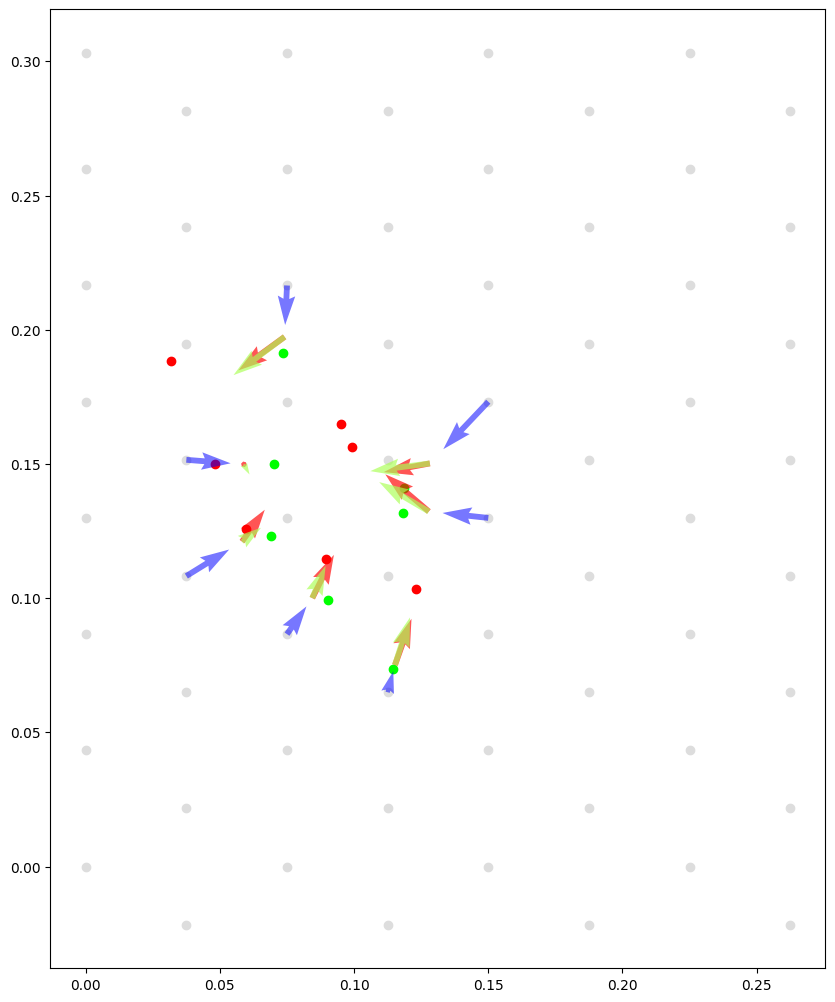

[[-0.0119 -0.0028]
 [-0.0208 -0.0224]
 [-0.0289 -0.0098]
 [-0.0258  0.0095]
 [-0.0046 -0.0282]
 [-0.0188  0.0237]
 [-0.0288 -0.0096]]
[[-0.0073 -0.0038]
 [-0.0192 -0.0227]
 [-0.0443 -0.0075]
 [-0.0317  0.0112]
 [-0.0058 -0.033 ]
 [-0.02    0.0227]
 [-0.0458 -0.006 ]]
7


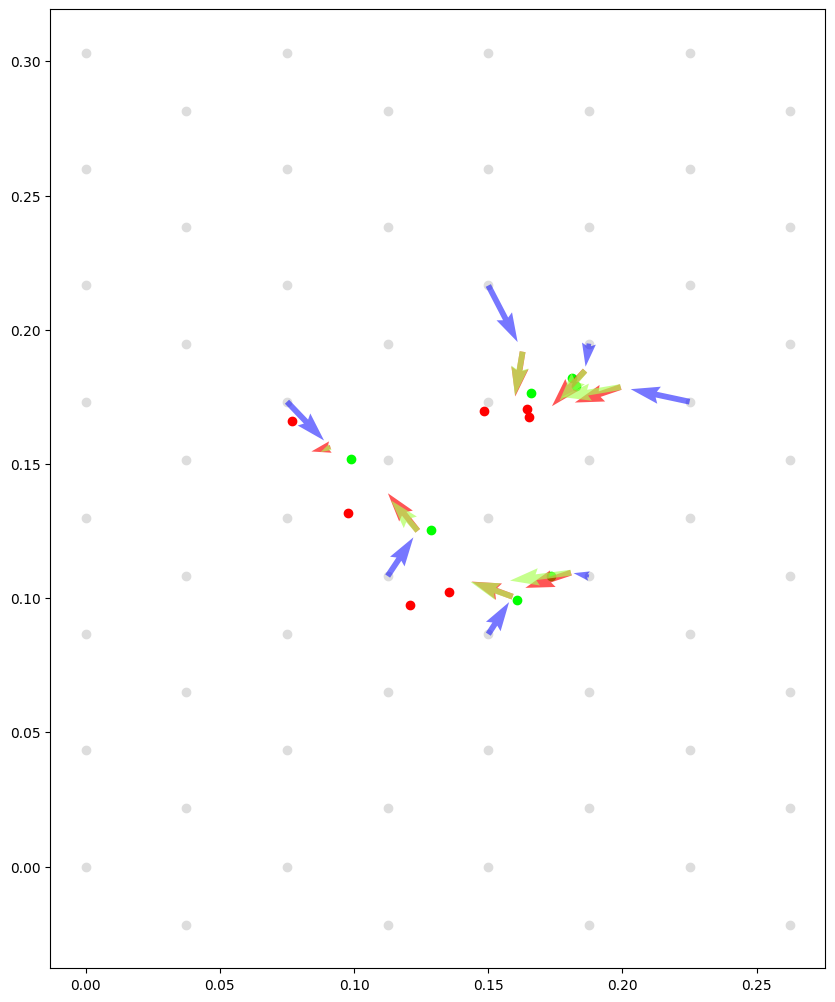

[[ 0.0213  0.007 ]
 [ 0.0103  0.0279]
 [ 0.0247  0.0295]
 [-0.0244 -0.0038]
 [-0.0199  0.0265]
 [-0.0129 -0.0093]
 [ 0.0103 -0.0263]]
[[ 0.0165 -0.0009]
 [ 0.0041  0.0302]
 [ 0.0236  0.04  ]
 [-0.0145 -0.0019]
 [-0.0154  0.0296]
 [-0.0066 -0.0077]
 [ 0.0144 -0.0363]]
7


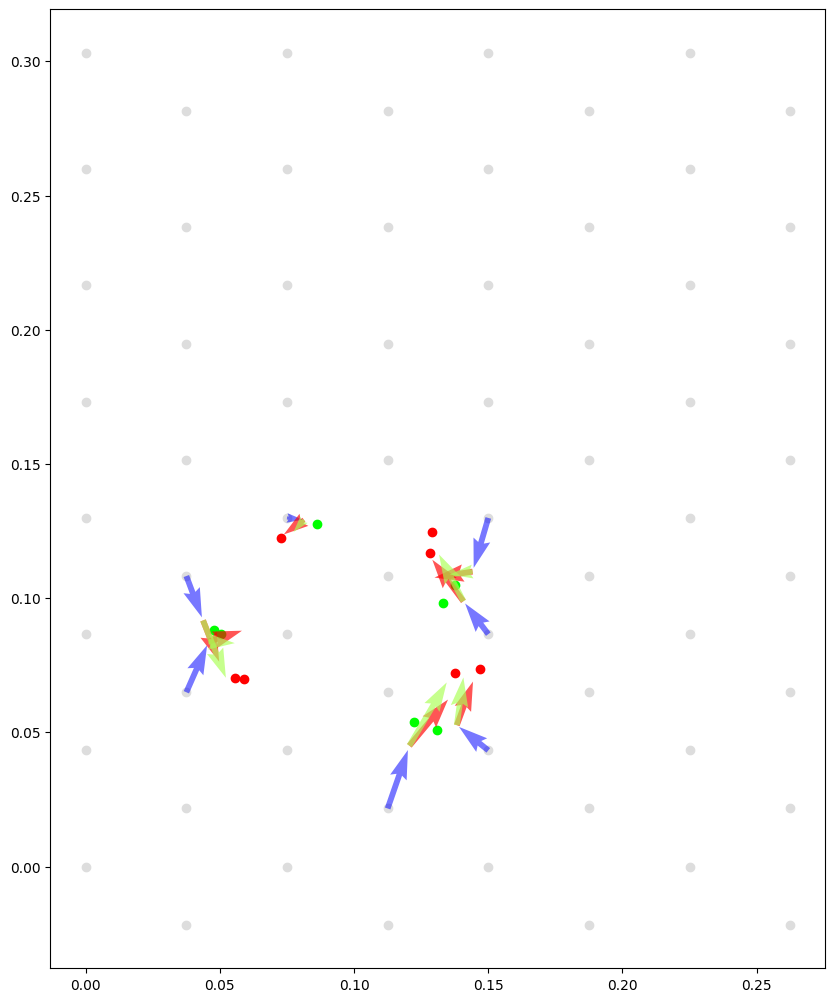

[[ 0.0262  0.0216]
 [ 0.0077 -0.0291]
 [ 0.0279 -0.0218]
 [ 0.0275 -0.0241]
 [ 0.02    0.0161]
 [ 0.0012 -0.0247]
 [ 0.0276 -0.0084]]
[[ 0.0313  0.0181]
 [ 0.0041 -0.046 ]
 [ 0.0314 -0.0208]
 [ 0.0322 -0.03  ]
 [ 0.0131  0.0061]
 [-0.0005 -0.0219]
 [ 0.0321 -0.0076]]
7


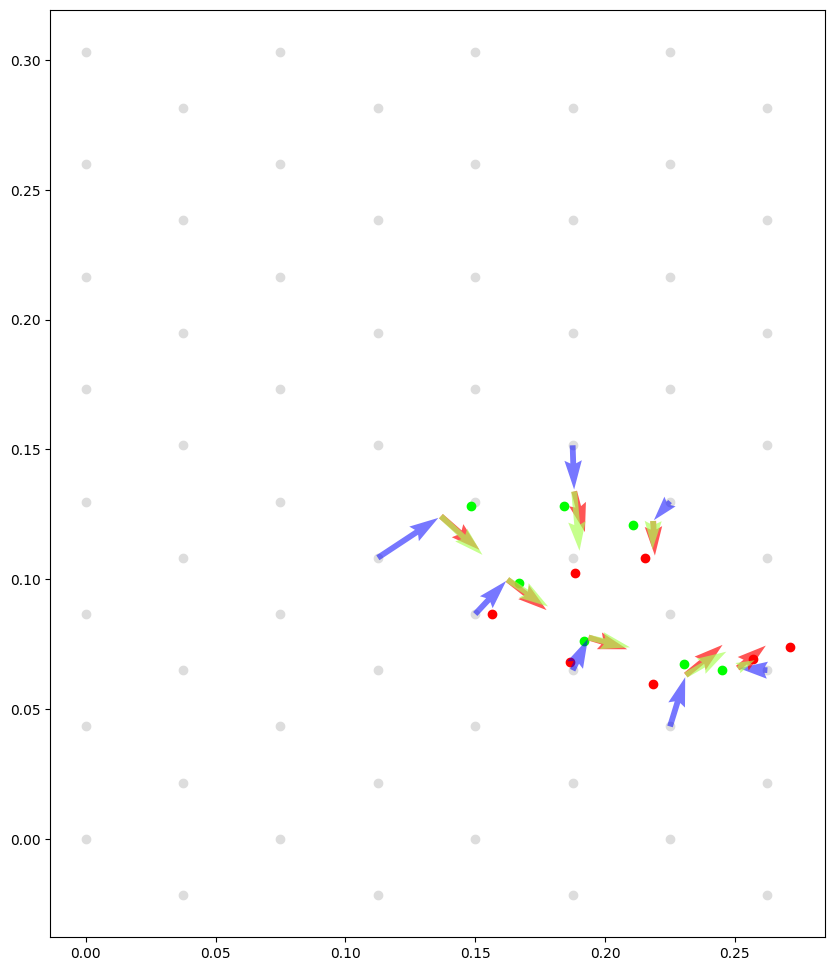

[[ 0.0291  0.0201]
 [ 0.0058  0.0195]
 [ 0.0271  0.0271]
 [-0.0185  0.0269]
 [ 0.0268  0.0257]
 [-0.0217  0.003 ]]
[[ 0.0443  0.0083]
 [ 0.0046  0.0063]
 [ 0.028   0.0185]
 [-0.0138  0.023 ]
 [ 0.0292  0.0138]
 [-0.0166 -0.0095]]
6


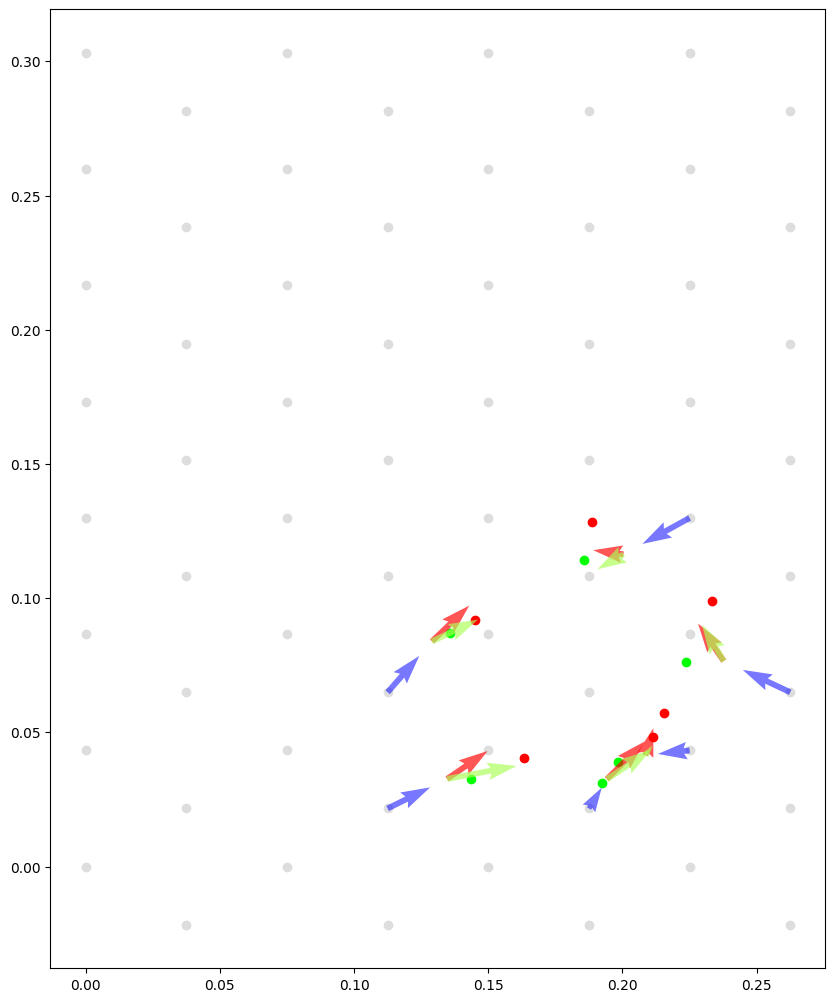

[[ 0.0068  0.0102]
 [-0.021  -0.0214]
 [-0.0058  0.0236]
 [-0.0279 -0.0222]
 [-0.0153 -0.0196]
 [-0.0275  0.0198]]
[[ 0.0018  0.0114]
 [-0.0176 -0.0176]
 [-0.0051  0.0278]
 [-0.0366 -0.0185]
 [-0.0128 -0.0108]
 [-0.0378  0.0117]]
6


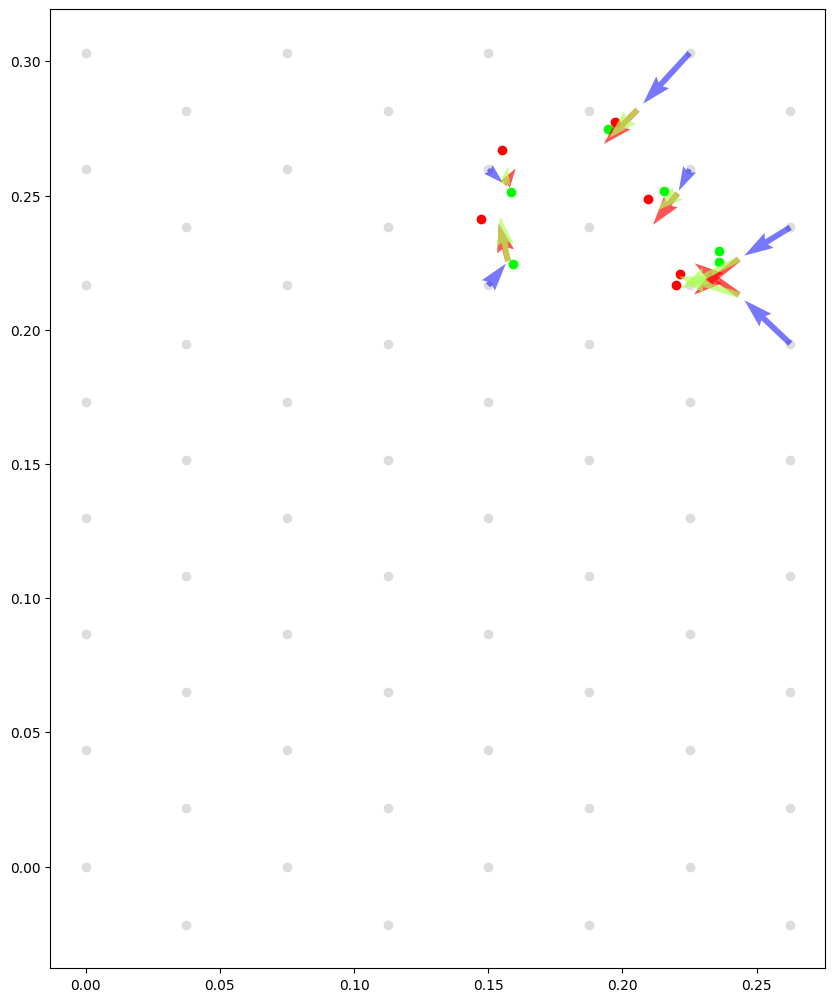

[[ 0.0018 -0.0082]
 [-0.0291 -0.015 ]
 [-0.0298 -0.0015]
 [-0.0262  0.0233]
 [-0.029   0.0238]
 [ 0.0065  0.0268]
 [-0.0014 -0.027 ]]
[[ 0.0019 -0.0064]
 [-0.0531 -0.0085]
 [-0.0724  0.0036]
 [-0.0281  0.0247]
 [-0.0457  0.0204]
 [ 0.0021  0.0308]
 [-0.0015 -0.0282]]
7


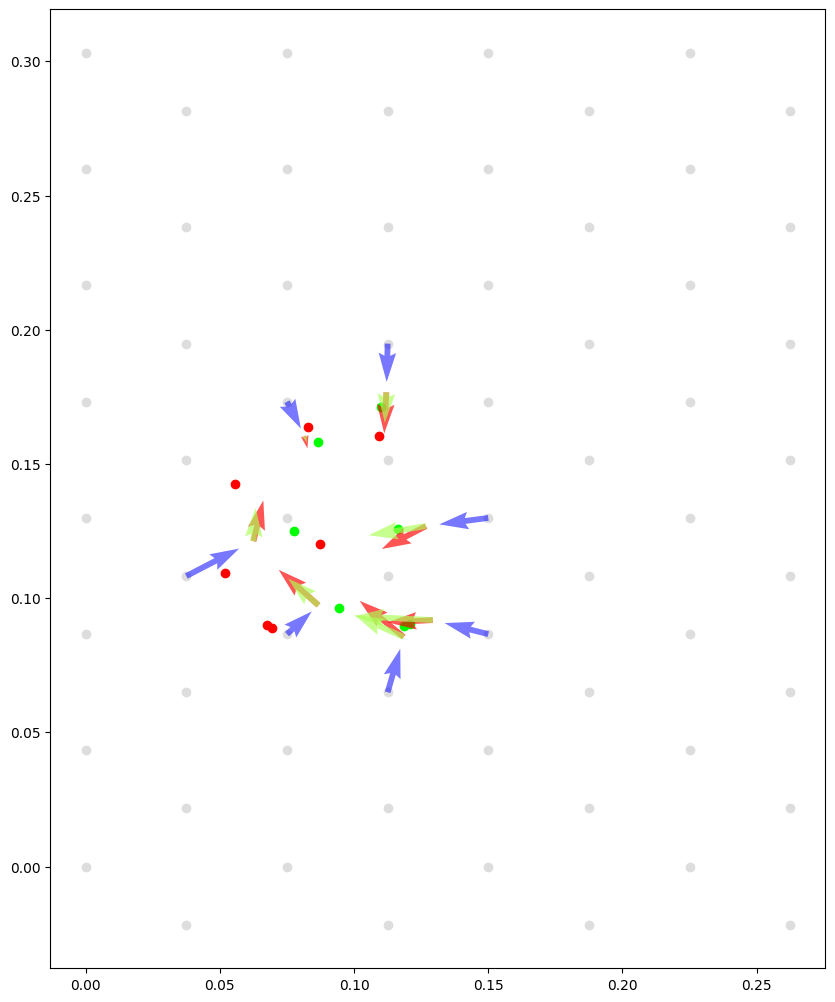

[[-0.0191 -0.0134]
 [ 0.0181 -0.0283]
 [-0.0051 -0.0273]
 [-0.0201 -0.029 ]
 [-0.0286 -0.019 ]]
[[-0.0133 -0.0127]
 [ 0.0174 -0.0377]
 [-0.0055 -0.0371]
 [-0.025  -0.0504]
 [-0.0387 -0.0185]]
5


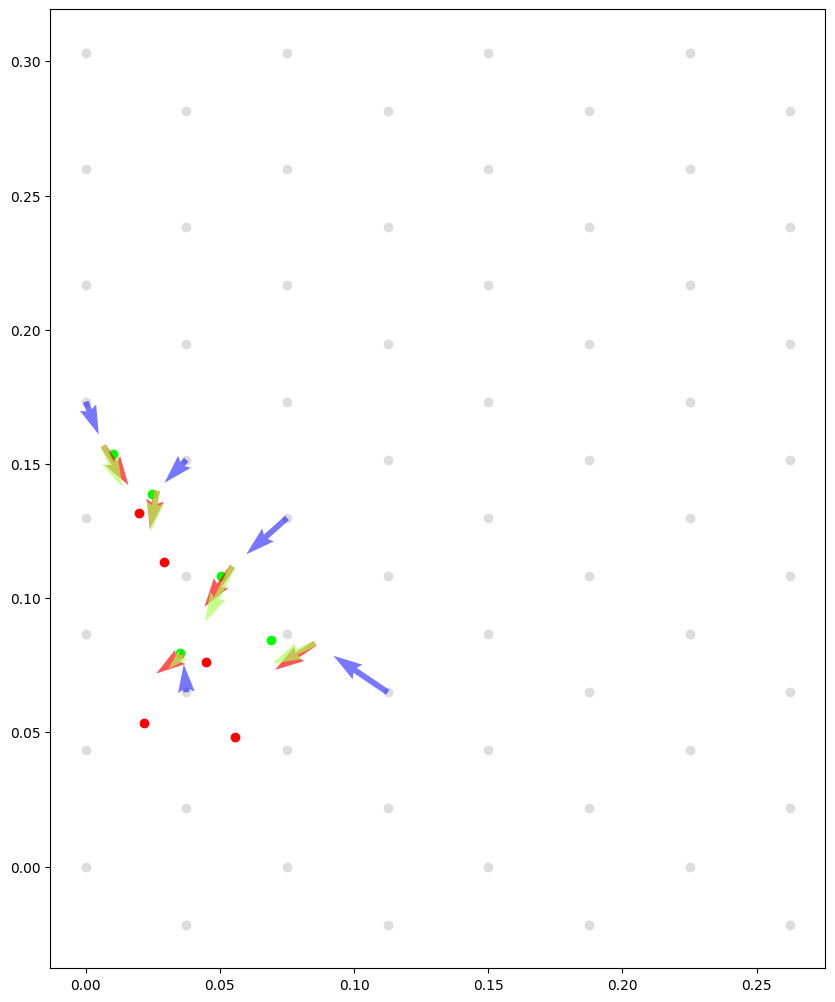

[[-0.0176 -0.0263]
 [-0.0294 -0.0061]
 [ 0.0174  0.0267]
 [-0.0207  0.0273]
 [ 0.0201  0.0015]]
[[-0.0109 -0.0329]
 [-0.0511 -0.0045]
 [ 0.0104  0.0323]
 [-0.0121  0.0271]
 [ 0.0129 -0.0013]]
5


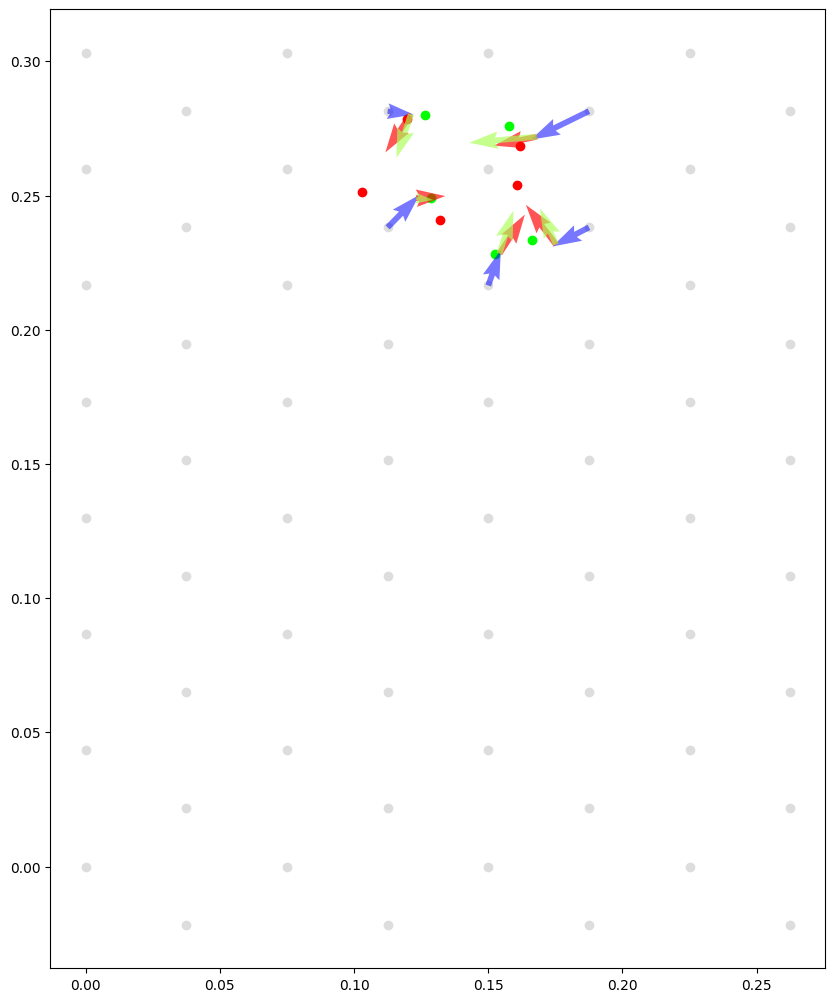

[[ 0.0265  0.0176]
 [-0.0299 -0.0134]
 [ 0.0264 -0.03  ]
 [-0.0293  0.0272]
 [-0.0213 -0.0295]
 [ 0.0295 -0.0295]
 [-0.0099  0.0282]]
[[ 0.0257  0.0154]
 [-0.0788 -0.0084]
 [ 0.0452 -0.0999]
 [-0.0517  0.0339]
 [-0.024  -0.0562]
 [ 0.0569 -0.0697]
 [-0.0108  0.0301]]
7


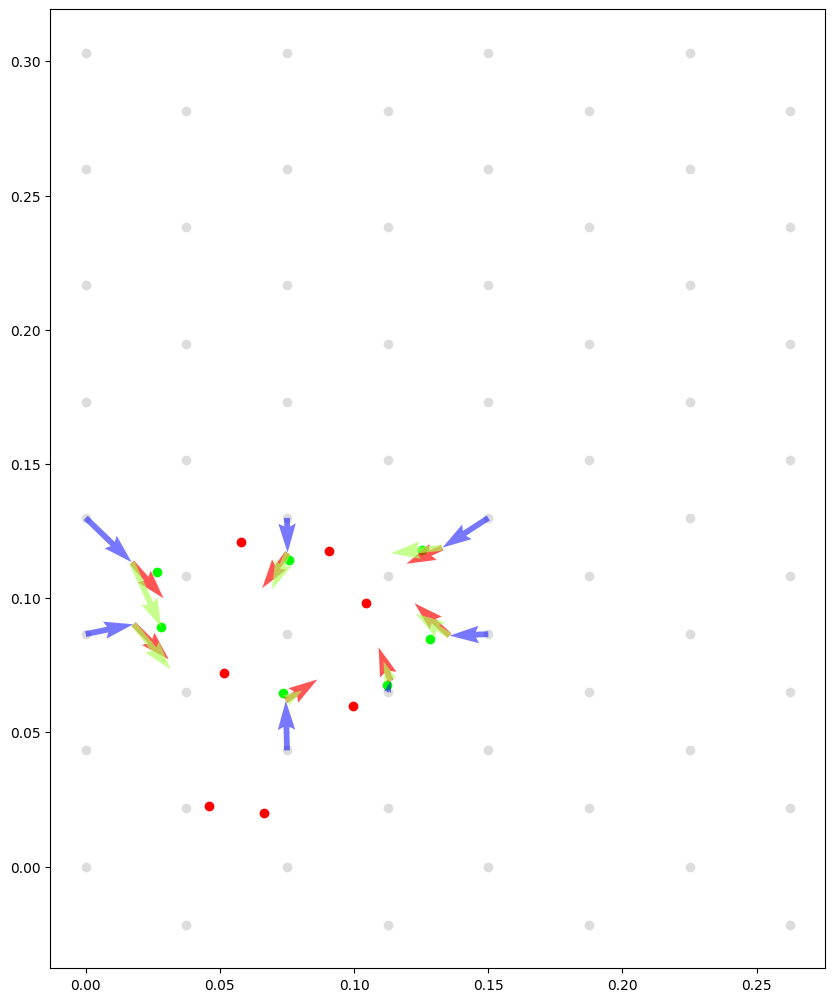

[[-0.0074  0.0248]
 [ 0.0013  0.0236]
 [ 0.0199  0.0257]
 [ 0.0007  0.0004]
 [ 0.0162  0.029 ]
 [-0.0147  0.0002]]
[[-0.0106  0.0146]
 [-0.0095  0.0195]
 [ 0.0067  0.017 ]
 [-0.0075 -0.0076]
 [ 0.0081  0.0414]
 [-0.0168 -0.0031]]
6


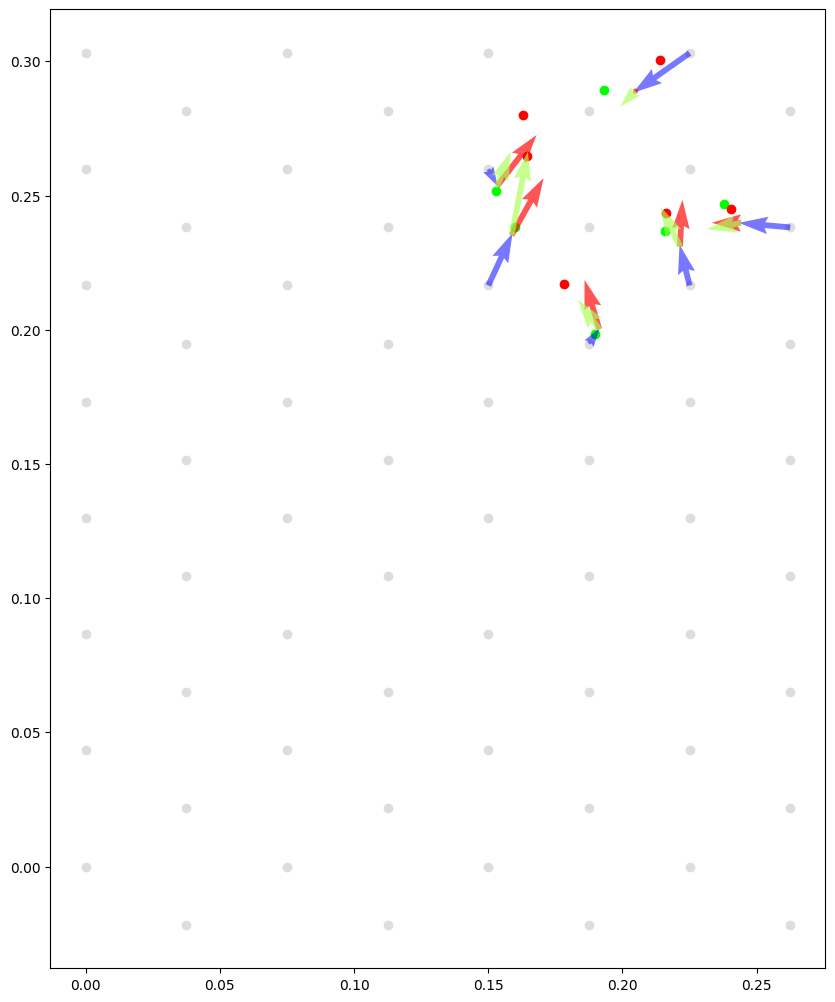

[[ 0.0077 -0.0017]
 [ 0.0053 -0.0169]
 [-0.0092  0.0254]
 [-0.0278 -0.0181]
 [-0.0128 -0.0188]
 [-0.0215  0.0275]]
[[-0.0009  0.0031]
 [-0.0024 -0.0117]
 [-0.0127  0.0259]
 [-0.0394 -0.0173]
 [-0.0143 -0.0107]
 [-0.0229  0.0332]]
6


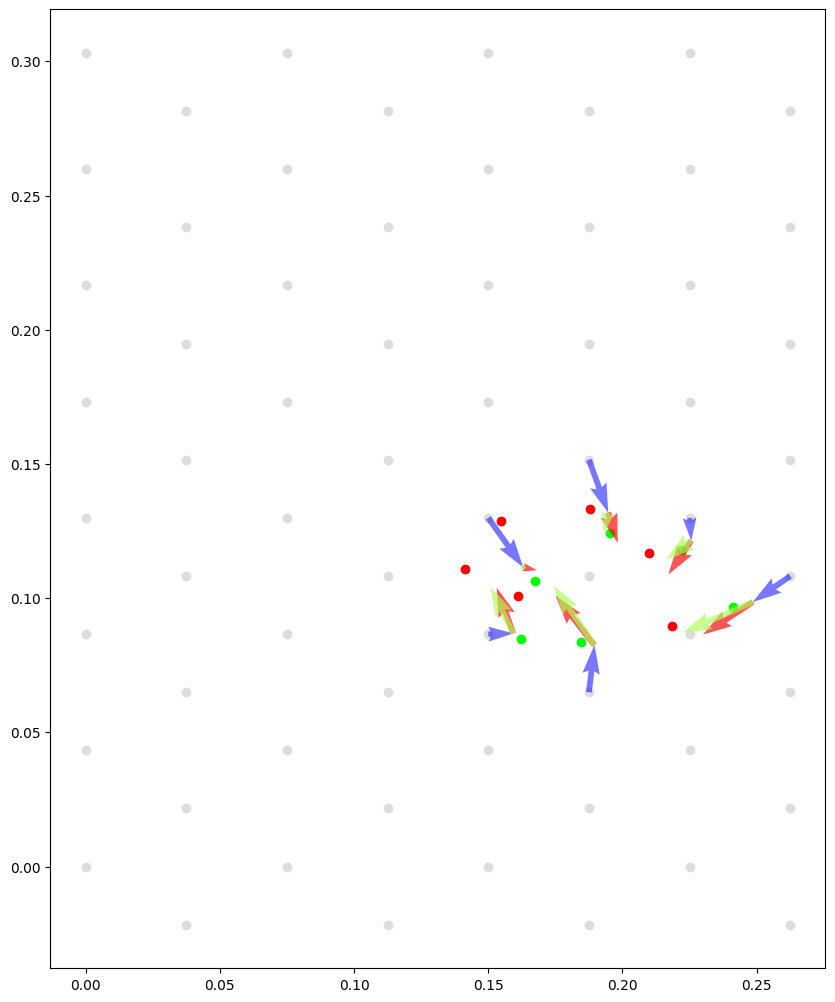

[[-0.0287 -0.0159]
 [ 0.0033  0.0053]
 [-0.0132  0.0192]
 [-0.0253  0.021 ]
 [-0.0289 -0.0287]]
[[-0.0345 -0.0119]
 [ 0.0024  0.0003]
 [-0.0083  0.0137]
 [-0.0274  0.0127]
 [-0.0393 -0.0465]]
5


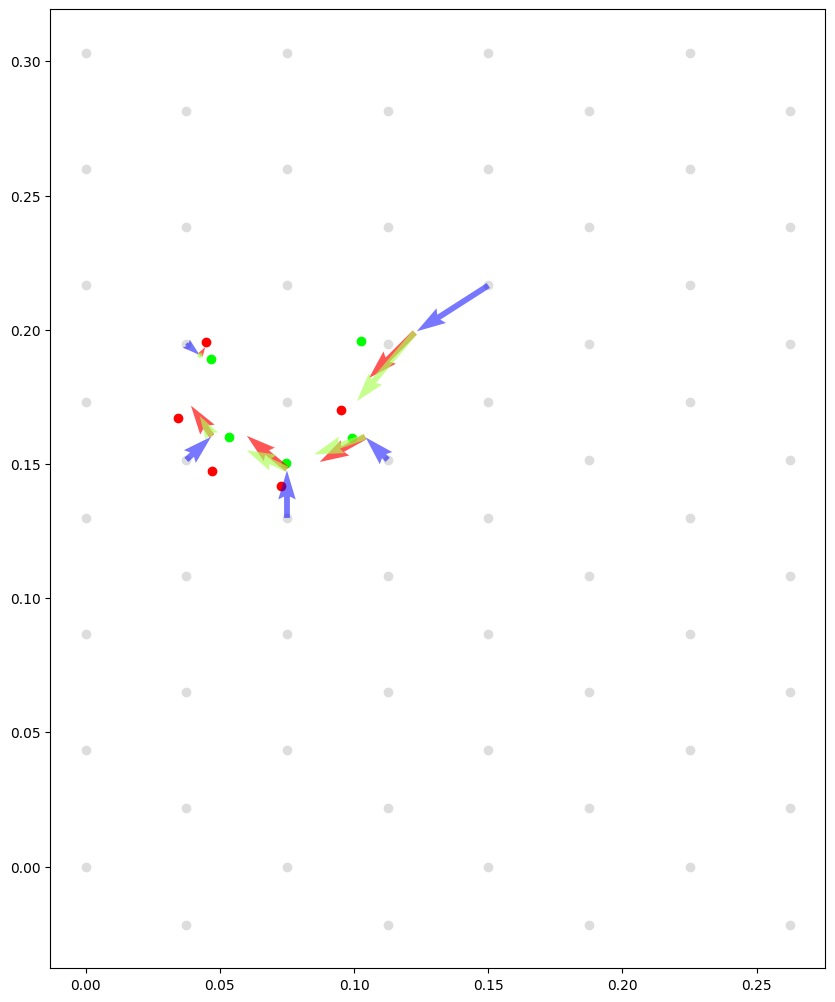

In [16]:
losses = []
for n, (state, action, action_gt, pos, N) in enumerate(zip(statesss, actionsss, actions_gt, possss, n_agents)):
    state, action, action_gt, pos = state, action, action_gt, pos
    pos = pos.squeeze(2).detach().cpu().numpy()
    acts = action.detach().cpu().numpy()
    acts_gt = action_gt.detach().cpu().numpy()
    state = state.detach().cpu().numpy()


    # state = state_scaler.inverse_transform(state)
    # acts = action_scaler.inverse_transform(acts)
    # acts_gt = action_scaler.inverse_transform(act_gt)

    for n, idx in enumerate(range(state.shape[0])):
    # idx = 0
        po = pos[idx]
        r_poses = kdtree_positions_world[po[:N]]
        init_pts = state[idx][:N,:2] + r_poses
        goal_bd_pts = state[idx][:N,2:4] + r_poses
        act_grsp = state[idx][:N,4:6]
        act = acts[idx]
        print(act)
        act_gt = acts_gt[idx, :N]
        print(act_gt)
        r_poses2 = r_poses + act_grsp

        losses.append(np.linalg.norm(act - act_gt))
        # acts = acts/np.linalg.norm(acts, axis=1).reshape(-1, 1)
        # act_gt = act_gt/np.linalg.norm(act_gt, axis=1).reshape(-1, 1)


        print(N)
        plt.figure(figsize=(10,17.78))
        plt.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], c='#ddddddff')
        plt.scatter(init_pts[:, 0], init_pts[:, 1], c = '#00ff00ff')
        plt.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='red')

        plt.quiver(r_poses[:, 0], r_poses[:, 1], act_grsp[:, 0], act_grsp[:, 1], color='#0000ff88')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act[:, 0], act[:, 1], color='#ff0000aa')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act_gt[:, 0], act_gt[:, 1], color='#aaff55aa')

        plt.gca().set_aspect('equal')
        plt.show()
        if n%30 == 0:
            break

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Dummy function to simulate pretrained diffusion model
def diffusion_model(state):
    # Generates dummy actions conditioned on state
    return np.sin(state) + np.random.normal(scale=0.1, size=state.shape)

# Dummy function to compute the score function for the actions
def compute_score_function(actions):
    # Compute a dummy score function for visualization
    return np.gradient(actions, axis=0)

# Example data
num_samples = 100
state_dim = 3  # Example state dimension
states = np.linspace(-10, 10, num_samples).reshape(-1, 1) * np.ones((1, state_dim))

# Generate actions using the pretrained diffusion model
actions = diffusion_model(states)

# Compute the score function for the actions
score_function = compute_score_function(actions)

# Create a 3D plot of the score function
fig = go.Figure()

for i in range(state_dim):
    # Add traces for each dimension of the score function
    fig.add_trace(go.Scatter3d(
        x=states[:, 0],
        y=actions[:, i],
        z=score_function[:, i],
        mode='lines',
        name=f'Score Dimension {i+1}',
        line=dict(width=4)
    ))

# Customize the layout for better presentation
fig.update_layout(
    title='3D Visualization of the Score Function',
    scene=dict(
        xaxis_title='State',
        yaxis_title='Action',
        zaxis_title='Score'
    ),
    legend=dict(x=0.1, y=0.9)
)

# Show the plot
fig.show()


In [ ]:
# BYOL for learning robot idx embeddings
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate a batch of integer indices
    # In a real scenario, you might want to sample these more carefully
    indices = torch.randint(0, num_embeddings, (batch_size,))  # Batch size of 32

    # "View 1" is just the embedding
    embedding1 = model(indices)

    # "View 2" could be the embedding of the next integer, simulating a simple 'transformation'
    # This is a simplistic approach; consider more sophisticated methods for your task
    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,))) % num_embeddings  # Ensure it wraps around at the max integer
    embedding2 = model(indices_2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
n_values = torch.arange(64)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
a = torch.randint(0, 64, (32,10))
op = model(a)
op.shape

In [ ]:
class ShapeEmbeddingModel(nn.Module):
    def __init__(self, num_bd_pts, hidden_dim, embed_dim):
        super(ShapeEmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer2 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer3 = nn.Linear(num_bd_pts, embed_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# def triplet_loss(anchor, positive, negative, margin=1.0):
#     distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, keepdim=True)
#     distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, keepdim=True)
#     losses = torch.relu(distance_positive - distance_negative + margin)
#     return losses.mean()


bd_pts_dict = pkl.load(open('../../config/assets/obj_props.pkl', 'rb'))
bd_pts = []
for name in bd_pts_dict.keys():
    bd_pts.append(bd_pts_dict[name][1].reshape(512,))

bd_pts = torch.tensor(bd_pts).float()

In [ ]:
# Model parameters
num_objects = 9
num_bd_pts = 256*2  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = ShapeEmbeddingModel(num_bd_pts, 512, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    indices = torch.randint(0, num_objects, (batch_size,))
    input1 = torch.index_select(data, 0, indices)
    embedding1 = model(input1)

    indices_2 = (indices + torch.randint(0, num_objects, (batch_size,))) % num_objects  # Ensure it wraps around at the max integer
    input2 = torch.index_select(data, 0, indices_2)
    embedding2 = model(input2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
